In [1]:

import numpy as np
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
import plotly.express as px
from plotly.offline import init_notebook_mode
#pio.renderers.default = "browser"
# Enable inline display
init_notebook_mode(connected=True)



In [2]:
## Helper function

''' Converts black box functions from np.arrays to pandas.DataFrames for easier interpretation of tabular data
Inputs:
    npa_x       inputs x1,x2,... as np array
    npa_y       output y as np array

Outputs:
    df          Dataframe with columns x1, x2, ... and y
'''

def fcn_as_df(npa_x,npa_y):
    # assure that even single rows have two dimensions - avoids breaking code below
    if npa_x.ndim == 1:
        npa_x = npa_x.reshape(1,-1)
        npa_y = npa_y.reshape(1,-1)

    n_col = npa_x.shape[1]
    col_names = [f"x{i+1}" for i in range(n_col)]
    df = pd.DataFrame(npa_x,columns=col_names)
    df["y"] = np.ravel(npa_y).T
    return df

''' Helper - Reads numpy arrays for each of the eight functions from disk and returns a list of dataframes containing the input and output info

Inputs: 
    path_to_fcns    Directory path - must contain folders "function_1","function_2"... each containing inputs.npy and outputs.npy 

Outputs: 
    fcn_dict - Dictionary of dataframes for each function, each dataframe containing columns x1, x2,..., y
'''


def read_fcns_from_disk(path_to_fcns):
    f_in = []
    f_out = []
    num_functions = 8
    # read the functions as a list of numpy arrays, separate for inputs x and output y
    for i in range(0, num_functions):
        dir_path = os.path.join(path_to_fcns, f'function_{i+1}')
        inputs = np.load(os.path.join(dir_path, 'inputs.npy'))
        outputs = np.load(os.path.join(dir_path, 'outputs.npy'))
        f_in.append(inputs)
        f_out.append(outputs)
        
    # create a dictionary of form {"f_1": DataFrame, "f_2": DataFrame, } where the DataFrames have column names x1, x2, ..., y
    fcn_dict = {}
    for i in range(0, num_functions):
        npa_x = f_in[i]
        npa_y = f_out[i]

        fcn_dict[f"f_{i+1}"] = fcn_as_df(npa_x,npa_y)

    return fcn_dict




In [3]:
# Helper function to print query point in expected format

def format_query(queryPoint):
    
    print(f"queryPoint={queryPoint}")

    # print the elements of the vector queryPoint, in the format 0.000000-0.000000-0.000000
    # where there is one 0.000000 per element in the vector

    query_str = '-'.join([f"{elem:.6f}" for elem in np.ravel(queryPoint)])
    print(f"queryPoint (formatted)={query_str}")

    #query_str=""
    #query_str.join(f"{queryPoint[0]:.6f}")
    #query_str.join([f"{elem:.6f}" for elem in np.ravel(queryPoint[1:])])
    #print(f"queryPoint (formatted)={query_str}")

# Helper Class for data transformations
Abstract class to allow users to apply transformations to the original data such as
- outlier imputation
- coordinate transformations

They can apply a transformation to a function by implementing this interface and invoking the transformation with the .transform() method of BBfcn

In [4]:
from abc import ABC, abstractmethod

class Transformation(ABC):
    @abstractmethod
    def apply(self,data):
        pass

# Main data structure - BBfcn (Black Box Function)
- Contains all known data points of the black box function as read from the directory /measurements/latest
- Implements methods to fit surrogate functions, grid acquisition functions, make graphs, estimate correlation coefficients, etc.


In [ ]:
import itertools

class BBfcn:

    latest_data_dir = os.path.join(".","measurements","latest")

    def __init__(self,function_number):
        self.function_number = function_number
        self.function_name = f"function_{function_number}"
        self.data_dir = os.path.join(self.latest_data_dir,self.function_name)
        self.__inputs = np.load(os.path.join(self.data_dir, 'inputs.npy'))
        self.__outputs = np.load(os.path.join(self.data_dir, 'outputs.npy'))
        self.data = fcn_as_df(self.__inputs,self.__outputs)
        self.update()

    # display the function
    def __str__(self):
        print(f"------------ {self.function_name} --------------")
        print(self.data)
        print(f"\nMax of {self.max} realized at row")
        print(self.argmax)
        return ""
    
    # update internal statistics after data modification
    def update(self):
        self.max = self.data["y"].max()
        self.argmax = self.data.loc[[self.data["y"].idxmax()]]
        self.input_dimension = self.data.shape[1]-1


    # API to allow user to apply a transformation or otherwise modify the data
    # they must implement tr, an instance of Transformation, including implementing mandatory method Transformation.apply()
    def transform(self, tr: Transformation):
        self._orig_data = self.data.copy()
        tr.apply(self.data) # pass the user the data for in-place modification. This should be the only way to modify the data
        self.update()
        
    def plot_feature_correlations(self):
        """
        Plot correlations between features and with target.
        """
        # 3. Pairwise scatterplots
        sns.pairplot(self.data)
        plt.show()

        # 1. Correlation matrix of features
        X_df = self.data.drop("y",axis=1).copy()
        #corr_matrix = X_df.corr()
        #plt.figure(figsize=(10, 8))
        #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
        #plt.title("Feature Correlation Matrix")
        #plt.show()
    
        # 2. Correlation with target
        corr_with_target = X_df.corrwith(self.data["y"])
        plt.figure(figsize=(10, 5))
        sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
        plt.xticks(rotation=45)
        plt.ylabel("Correlation with Target")
        plt.title("Feature Correlation with Target")
        plt.show()

    def plot_correlations_with_cross_terms(self):
        df = self.data.copy()
    
        # original feature columns
        feature_cols = df.columns[:-1]
    
        # Generate all pairwise cross terms
        for col1, col2 in itertools.combinations(feature_cols, 2):
            cross_col_name = f'{col1}*{col2}'
            df[cross_col_name] = df[col1] * df[col2]
    
        # Compute correlation of each column with the target
        corr_with_target = df.corr()["y"].sort_values(ascending=False)
    
        # Plot
        plt.figure(figsize=(10, max(4, len(corr_with_target)/2)))
        sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
        plt.title(f'Correlation of features with target')
        plt.xlabel('Correlation')
        plt.ylabel('Feature')
        plt.show()

    def ucb(self,X_candidate, gp, kappa=2.0):
        mu, sigma = gp.predict(X_candidate, return_std=True)
        return mu + kappa * sigma

    def nextPointBayesianOptim(self,kernel,numgrid=20,acqFcn="UCB",beta=0.5):
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)
        y_train = self.data.iloc[:,-1].to_numpy()  # output is in last column
        X_train = self.data.iloc[:,:-1].to_numpy() # other columns are inputs 
        gp.fit(X_train, y_train)
        print("GP kernel=")
        print(gp.kernel)
        #kernel_params = gp.kernel_.get_params()
        #print(kernel_params["k2__length_scale"])     # Access Matern length scale

        x = []
        for i in range(self.input_dimension):
            x.append(np.linspace(0,1,numgrid))

        xvalue_grids = np.meshgrid(*x,indexing="ij")
        flat = [g.reshape(-1) for g in xvalue_grids]
        X_for_gp = np.vstack(flat).T
        
        # Acquisition function      
        mu, sigma = gp.predict(X_for_gp, return_std=True)
        ucb = mu + beta * sigma

        # Select next acquisition point ---
        next_idx = np.argmax(ucb)
        X_next = X_for_gp[next_idx]
        print("Next acquisition point (UCB):", X_next)
        format_query(X_next)

        # Interactive plot for 2D
        if self.input_dimension == 2:
            y_GP = mu.reshape(xvalue_grids[0].shape)
            dimension_names = self.data.columns[:-1].tolist()
            # Mean of Gaussian Process
            fig = go.Figure(data=[go.Surface(z=y_GP, x=xvalue_grids[0], y=xvalue_grids[1], opacity=0.4)])
            fig.update_layout(scene=dict(
                xaxis_title=dimension_names[0],
                yaxis_title=dimension_names[1],
                zaxis_title=f'f({dimension_names[0]},{dimension_names[1]})'))
            # original data points
            fig.add_trace(go.Scatter3d(
                x=X_train[:, 0],
                y=X_train[:, 1],
                z=y_train,
                mode='markers',
                marker=dict(color='red', size=5),
                name='Measured points'))
            fig.show()

BEFORE DATA TRANSFORMATION
---
------------ function_1 --------------
       x1     x2           y
0   0.319  0.763   1.323e-79
1   0.574  0.880   1.033e-46
2   0.731  0.733   7.711e-16
3   0.840  0.265  3.342e-124
4   0.650  0.682  -3.606e-03
5   0.410  0.148  -2.159e-54
6   0.313  0.079  -2.089e-91
7   0.683  0.861   2.535e-40
8   0.083  0.403   3.607e-81
9   0.884  0.582   6.230e-48
10  0.997  1.000  3.216e-191
11  0.653  0.204   5.750e-71
12  0.000  1.000   0.000e+00
13  0.000  0.735 -1.009e-192
14  0.653  1.000  -3.699e-97

Max of 7.710875114502849e-16 realized at row
      x1     x2          y
2  0.731  0.733  7.711e-16



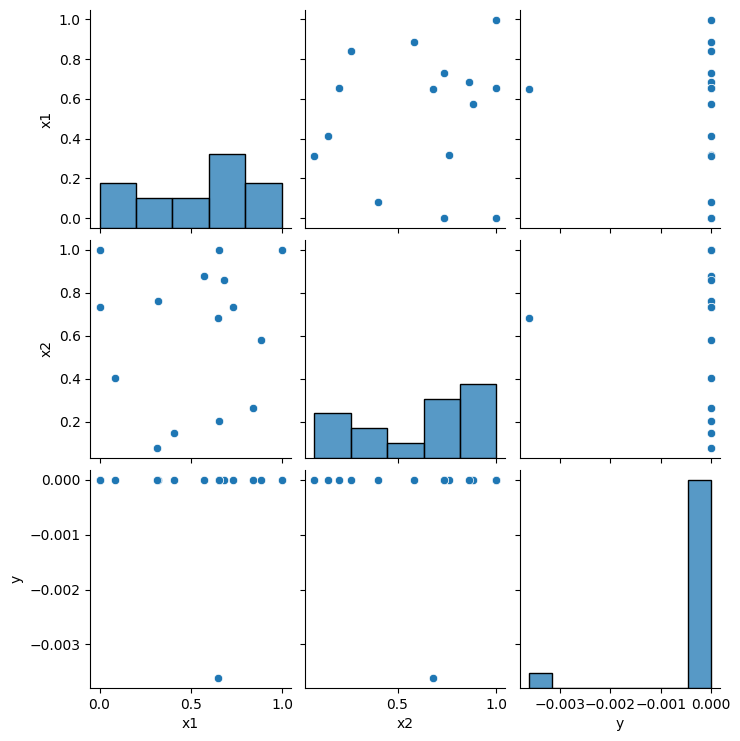

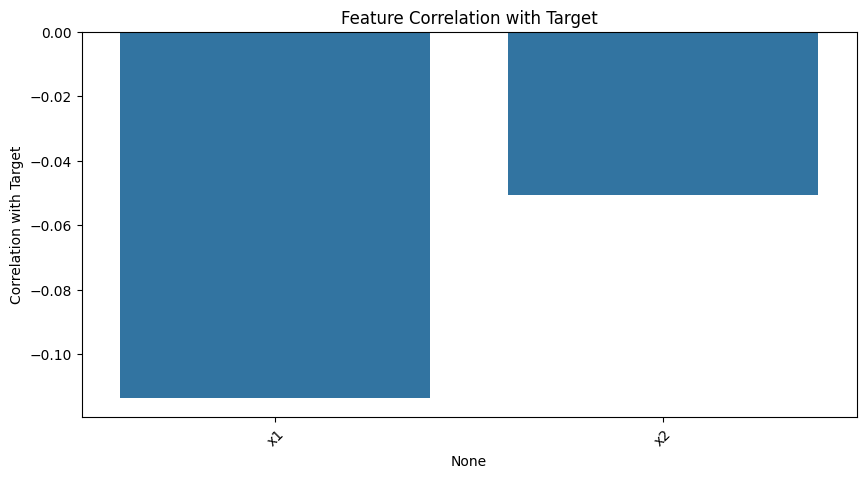

AFTER DATA TRANSFORMATION
---
------------ function_1 --------------
       x1     x2      y
0   0.319  0.763  0.000
1   0.574  0.880  0.115
2   0.731  0.733  1.000
3   0.840  0.265  0.000
4   0.650  0.682  0.000
5   0.410  0.148  0.000
6   0.313  0.079  0.000
7   0.683  0.861  0.298
8   0.083  0.403  0.000
9   0.884  0.582  0.080
10  0.997  1.000  0.000
11  0.653  0.204  0.000
12  0.000  1.000  0.000
13  0.000  0.735  0.000
14  0.653  1.000  0.000

Max of 1.0 realized at row
      x1     x2    y
2  0.731  0.733  1.0



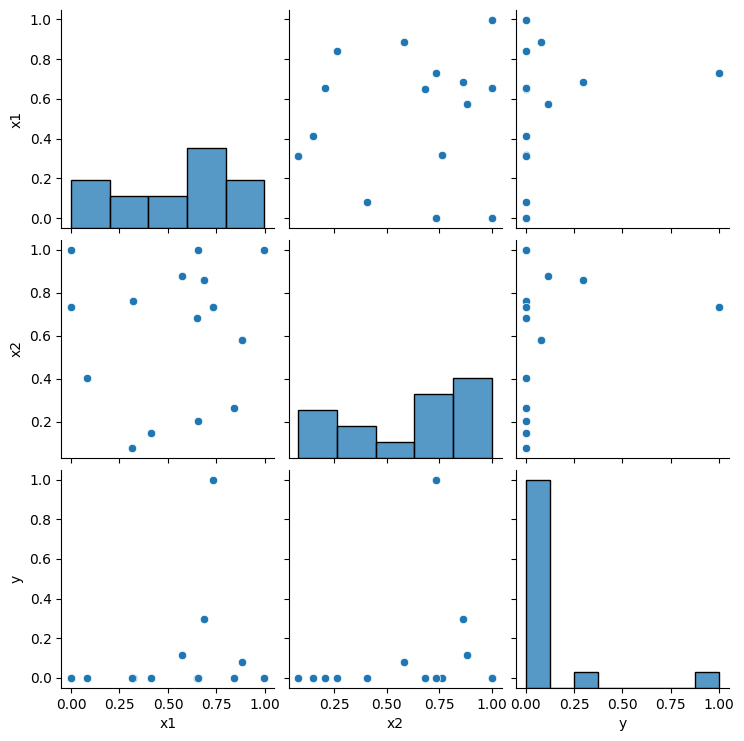

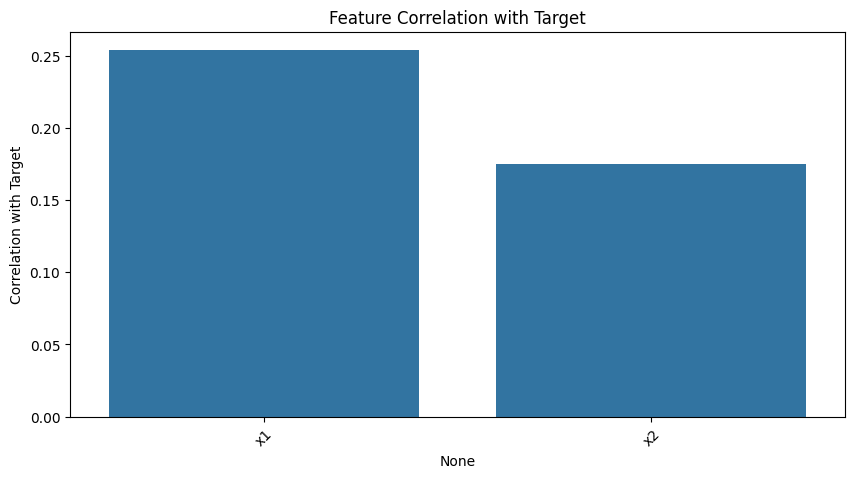

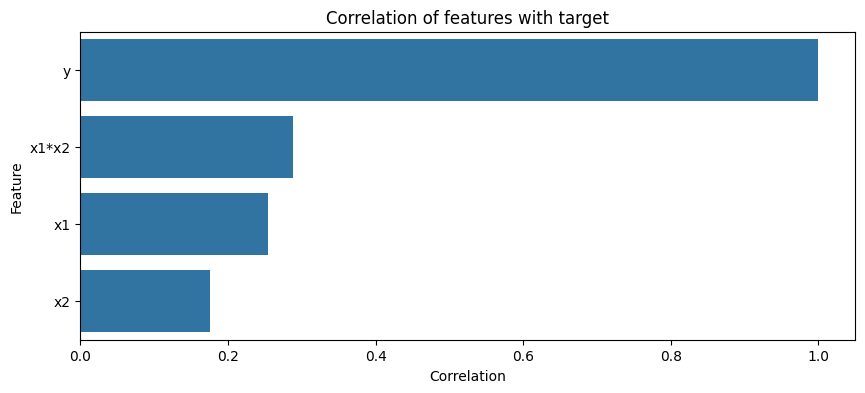

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.01)
Next acquisition point (UCB): [0.73684211 1.        ]
queryPoint=[0.73684211 1.        ]
queryPoint (formatted)=0.736842-1.000000


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



In [6]:
#pd.set_option('display.float_format', '{:.2g}'.format)
#pd.reset_option('display.float_format')
pd.set_option("display.precision",3)

f1 = BBfcn(1)
print("BEFORE DATA TRANSFORMATION")
print("---")
print(f1)
f1.plot_feature_correlations()

print("AFTER DATA TRANSFORMATION")
print("---")
# Customer strategy for f1() to remove negative values and take log of y
class f1_scale_and_outliers(Transformation):
    def __init__(self):
        self.substitute_val_for_negatives = 1e-50
    
    def apply(self,data):
        data.loc[data["y"]<1e-70,"y"] = self.substitute_val_for_negatives
        data["y"] = np.log10(data["y"])
        scaler = MinMaxScaler(feature_range=(0, 1))
        data["y"] = scaler.fit_transform(data[["y"]])
        #data.drop(data.tail(4).index, inplace=True)


tr = f1_scale_and_outliers()
f1.transform(tr)
print(f1)
f1.plot_feature_correlations()
f1.plot_correlations_with_cross_terms()
#kernel = C(1, (1e-5, 10)) * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01)
kernel = C(10, (0.001, 10)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=0.01)
f1.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)



In [7]:
f2 = BBfcn(2)
print(f2)

# f2.plot_feature_correlations()
# f2.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[1,1],nu=2.5) + WhiteKernel(noise_level=0.2)
f2.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

------------ function_2 --------------
       x1     x2      y
0   0.666  0.124  0.539
1   0.878  0.779  0.421
2   0.143  0.349 -0.066
3   0.845  0.711  0.294
4   0.455  0.290  0.215
5   0.578  0.772  0.023
6   0.438  0.685  0.245
7   0.342  0.029  0.039
8   0.339  0.214 -0.014
9   0.703  0.927  0.611
10  0.758  1.000  0.241
11  0.000  0.000 -0.009
12  0.000  1.000 -0.138
13  0.694  0.755  0.552
14  0.694  0.755  0.646

Max of 0.6458577203776756 realized at row
       x1     x2      y
14  0.694  0.755  0.646

GP kernel=
3.16**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=0.2)
Next acquisition point (UCB): [0.68421053 1.        ]
queryPoint=[0.68421053 1.        ]
queryPoint (formatted)=0.684211-1.000000


------------ function_3 --------------
       x1     x2     x3      y
0   0.172  0.344  0.249 -0.112
1   0.242  0.644  0.272 -0.088
2   0.535  0.399  0.173 -0.111
3   0.493  0.612  0.340 -0.035
4   0.135  0.220  0.458 -0.048
5   0.346  0.941  0.269 -0.111
6   0.152  0.440  0.991 -0.399
7   0.646  0.397  0.920 -0.114
8   0.747  0.284  0.226 -0.131
9   0.170  0.697  0.149 -0.094
10  0.221  0.298  0.344 -0.047
11  0.666  0.672  0.246 -0.106
12  0.047  0.231  0.771 -0.118
13  0.600  0.725  0.066 -0.036
14  0.966  0.861  0.567 -0.057
15  0.805  1.000  0.556 -0.065
16  0.000  0.000  0.000 -0.184
17  0.000  1.000  0.776 -0.131
18  0.000  0.000  0.653 -0.172
19  1.000  0.000  0.673 -0.195

Max of -0.034835313350078584 realized at row
      x1     x2    x3      y
3  0.493  0.612  0.34 -0.035



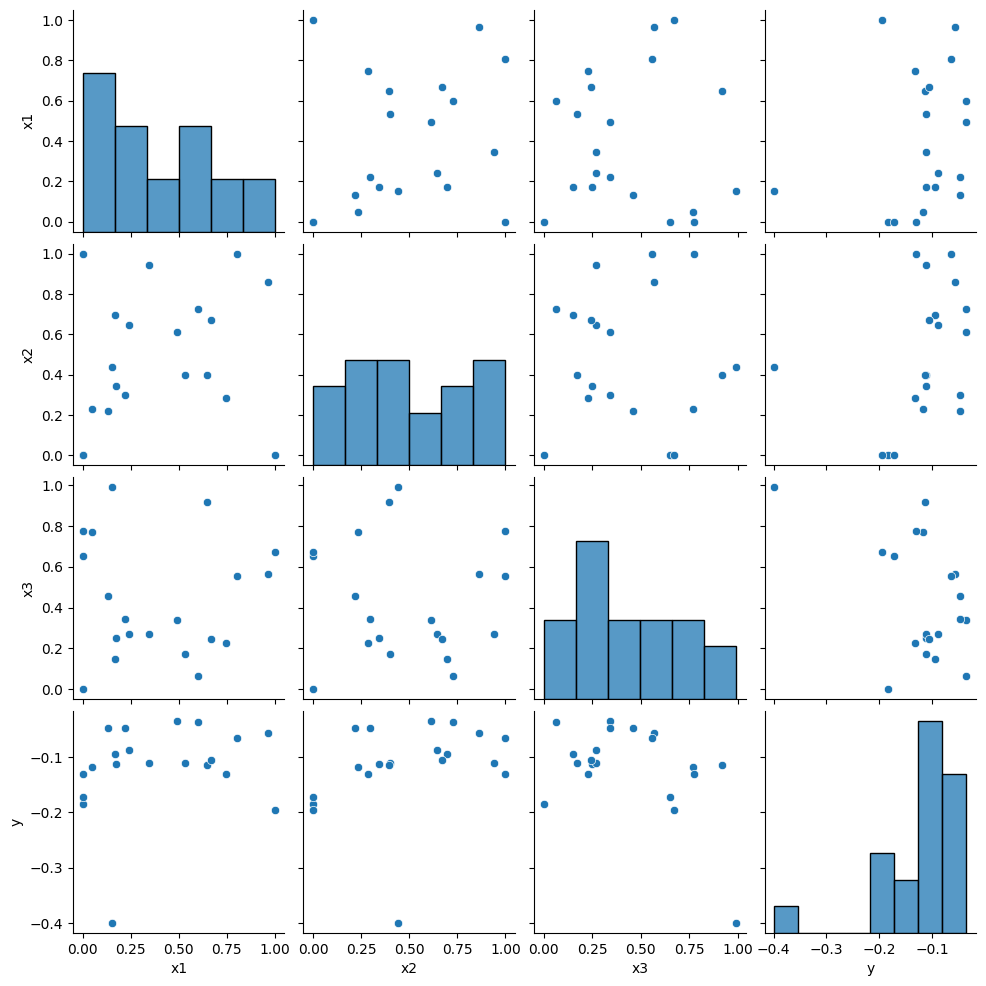

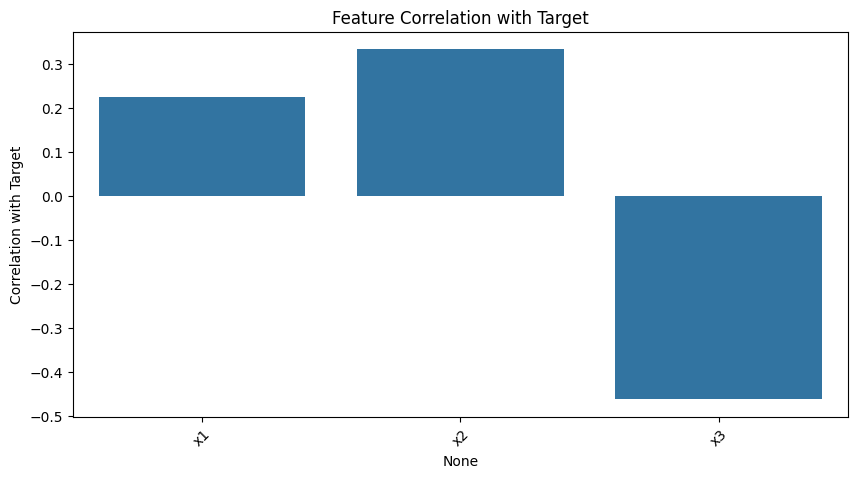

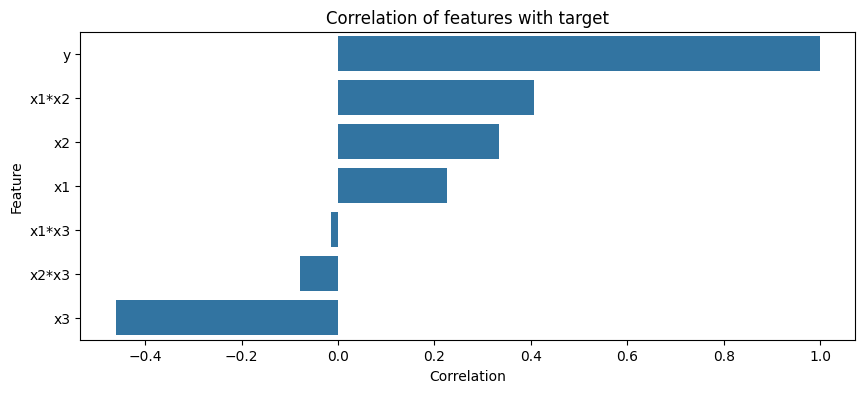

In [8]:
f3 = BBfcn(3)
print(f3)
f3.plot_feature_correlations()
f3.plot_correlations_with_cross_terms()

# f_3() - Dimension Reduction and Gaussian Process fit
- Keep x2 and x3
- Treat x1 as "noise" on the other two

------------ function_3 --------------
       x2     x3      y
0   0.344  0.249 -0.112
1   0.644  0.272 -0.088
2   0.399  0.173 -0.111
3   0.612  0.340 -0.035
4   0.220  0.458 -0.048
5   0.941  0.269 -0.111
6   0.440  0.991 -0.399
7   0.397  0.920 -0.114
8   0.284  0.226 -0.131
9   0.697  0.149 -0.094
10  0.298  0.344 -0.047
11  0.672  0.246 -0.106
12  0.231  0.771 -0.118
13  0.725  0.066 -0.036
14  0.861  0.567 -0.057
15  1.000  0.556 -0.065
16  0.000  0.000 -0.184
17  1.000  0.776 -0.131
18  0.000  0.653 -0.172
19  0.000  0.673 -0.195

Max of -0.034835313350078584 realized at row
      x2    x3      y
3  0.612  0.34 -0.035



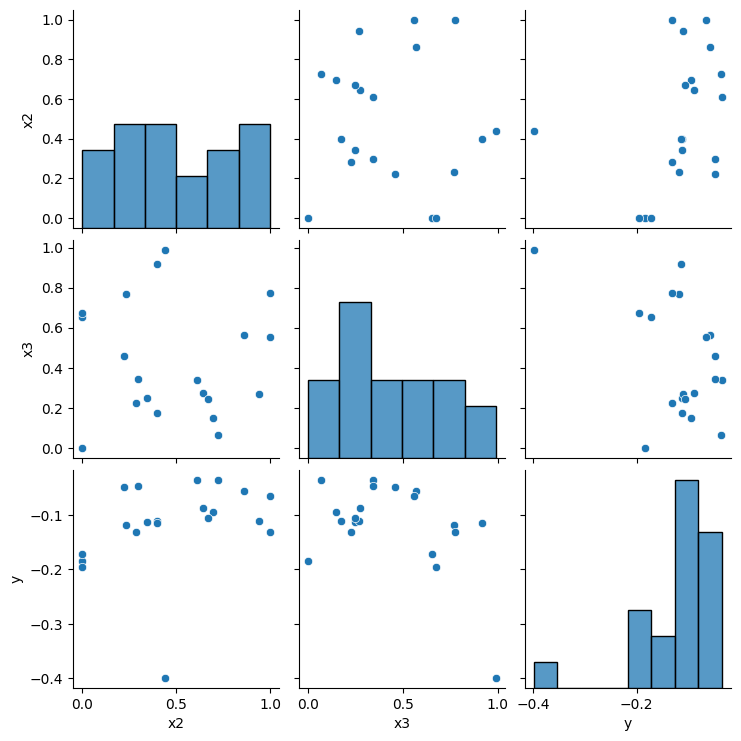

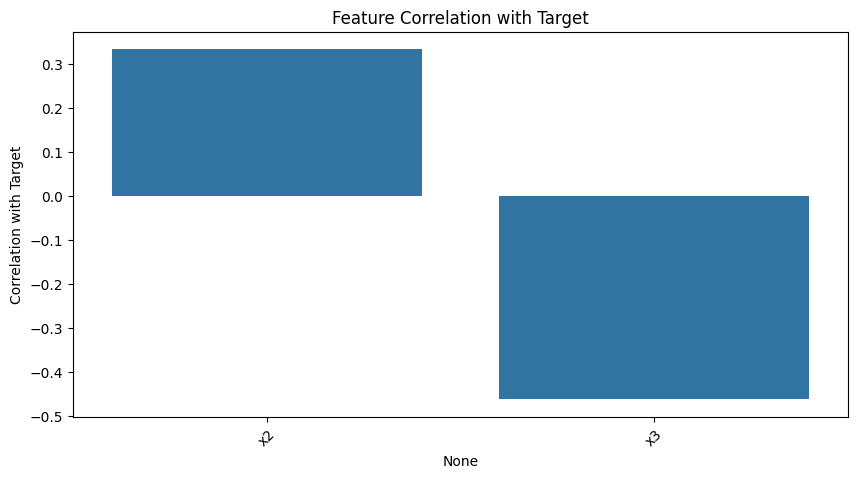

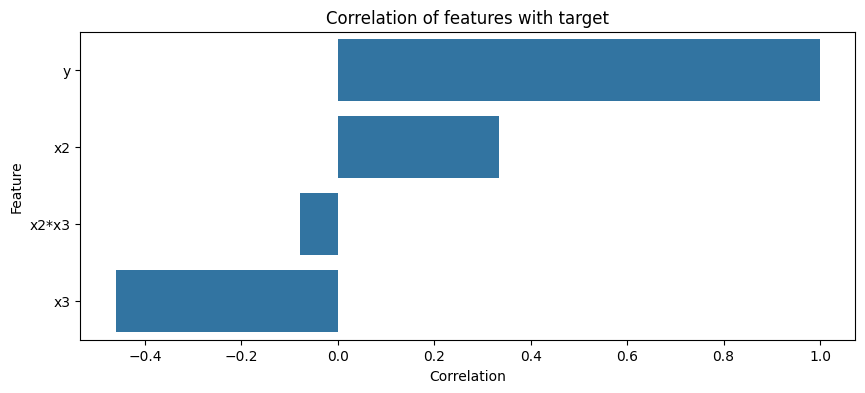

GP kernel=
3.16**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [1.         0.42105263]
queryPoint=[1.         0.42105263]
queryPoint (formatted)=1.000000-0.421053


GP kernel=
3.16**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [1.         1.         0.42105263]
queryPoint=[1.         1.         0.42105263]
queryPoint (formatted)=1.000000-1.000000-0.421053


In [9]:
f3_dimRed = BBfcn(3)

# strategy class for f3() to reduce dimension by removing x1
class f3dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1"],inplace=True)

tr = f3dimRedTransform()
f3_dimRed.transform(tr)
print(f3_dimRed)
f3_dimRed.plot_feature_correlations()
f3_dimRed.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[1,1],nu=2.5) + WhiteKernel(noise_level=0.1)
f3_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

kernel = C(10, (0.001, 10)) * Matern(length_scale=[1,1,1],nu=2.5) + WhiteKernel(noise_level=0.1)
f3.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

# f_4()

------------ function_4 --------------
       x1     x2     x3     x4       y
0   0.897  0.726  0.175  0.702 -22.108
1   0.889  0.500  0.539  0.509 -14.601
2   0.251  0.034  0.145  0.495 -11.700
3   0.347  0.006  0.761  0.613 -16.054
4   0.125  0.130  0.384  0.287 -10.070
5   0.801  0.500  0.707  0.195 -15.487
6   0.248  0.060  0.042  0.441 -12.682
7   0.747  0.757  0.369  0.207 -16.026
8   0.401  0.073  0.887  0.244 -17.049
9   0.626  0.587  0.439  0.779 -12.742
10  0.957  0.598  0.766  0.776 -27.316
11  0.733  0.145  0.477  0.133 -13.528
12  0.655  0.072  0.687  0.082 -16.679
13  0.220  0.832  0.483  0.083 -16.507
14  0.489  0.212  0.939  0.376 -17.818
15  0.167  0.877  0.217  0.960 -26.562
16  0.217  0.166  0.241  0.770 -12.758
17  0.387  0.805  0.752  0.724 -19.442
18  0.986  0.667  0.157  0.857 -28.903
19  0.038  0.665  0.162  0.254 -13.703
20  0.683  0.903  0.335  0.999 -29.427
21  0.170  0.757  0.277  0.531 -11.566
22  0.860  0.920  0.206  0.098 -26.858
23  0.282  0.506  0.531  

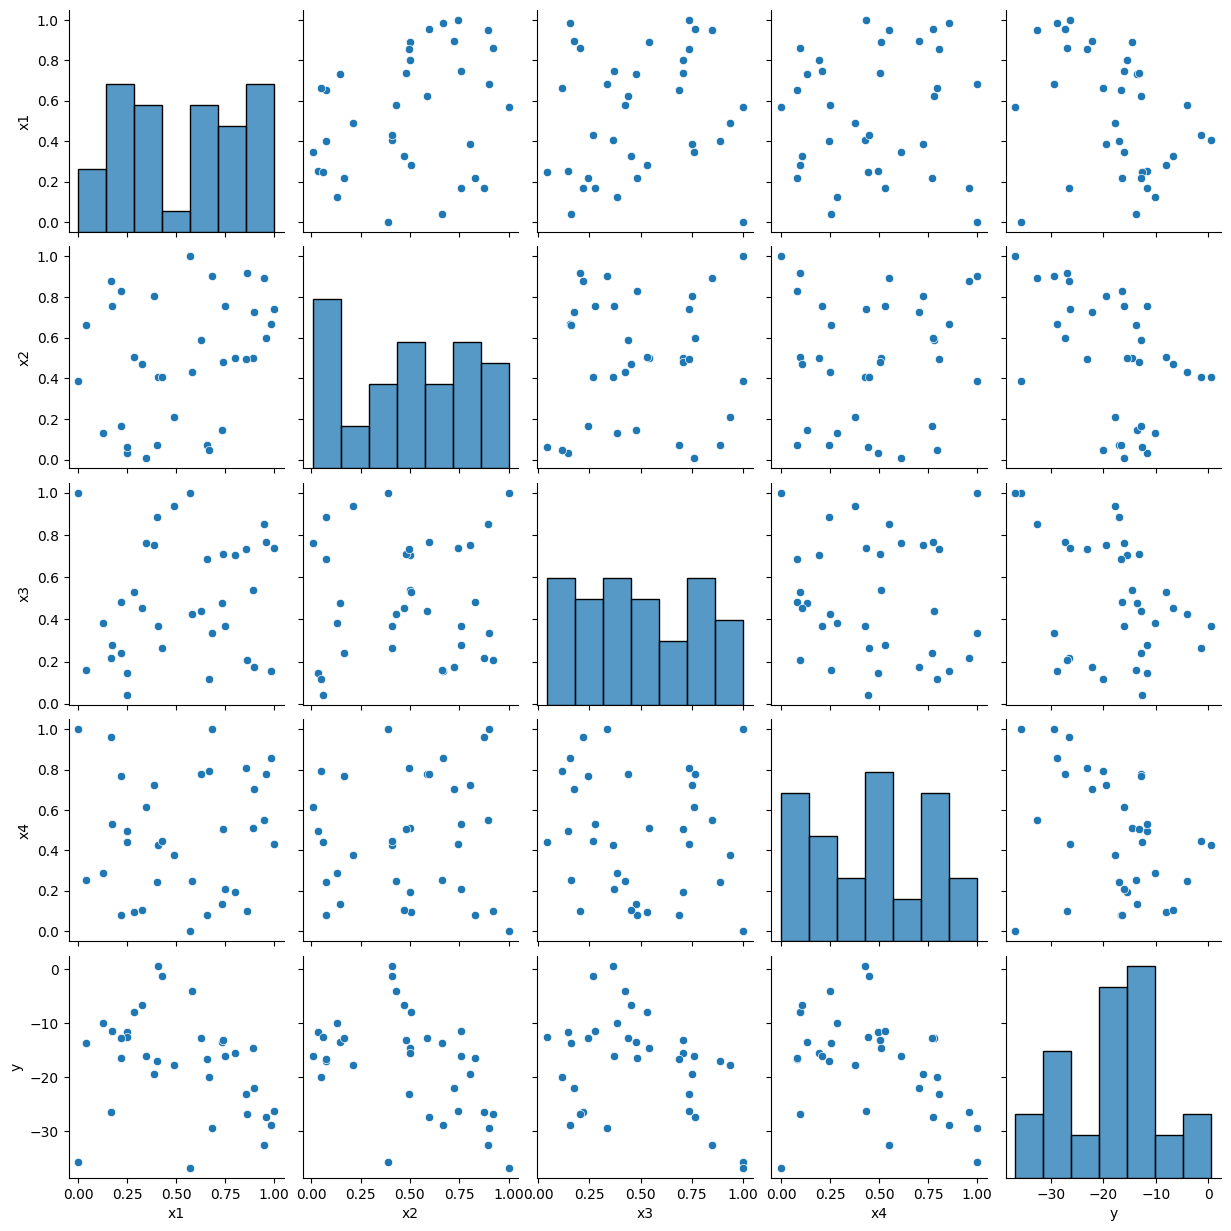

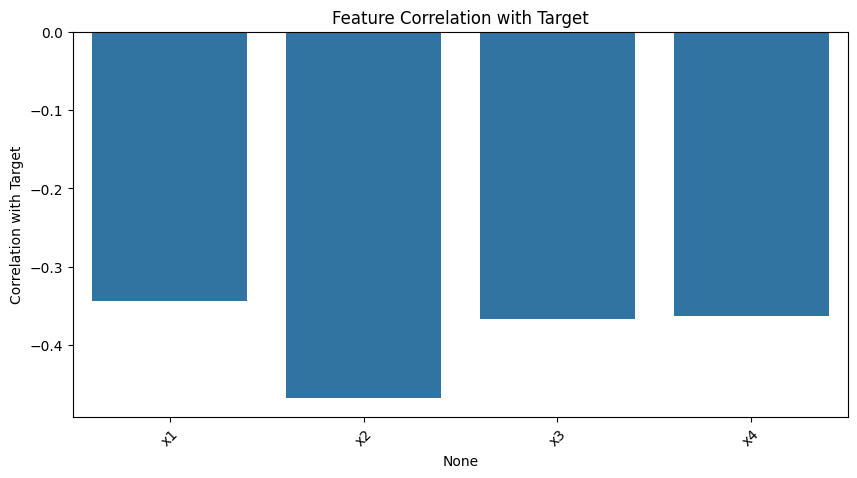

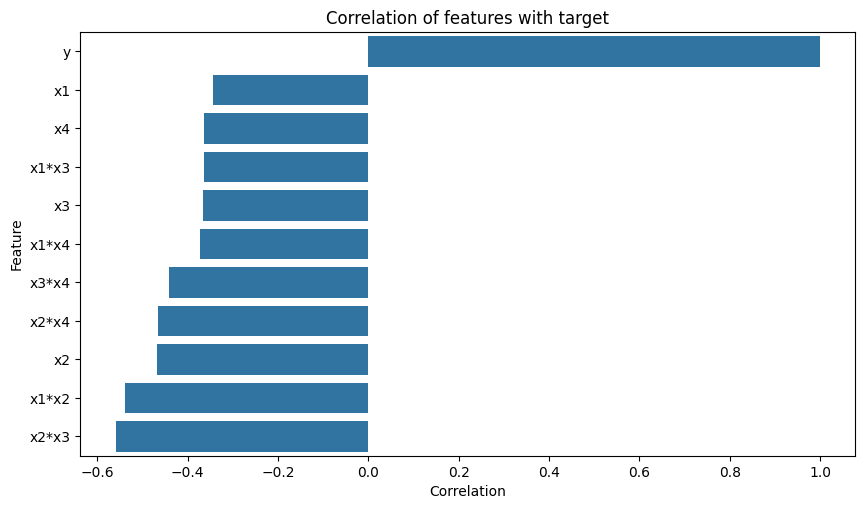

------------ function_4 --------------
       x2     x3       y
0   0.726  0.175 -22.108
1   0.500  0.539 -14.601
2   0.034  0.145 -11.700
3   0.006  0.761 -16.054
4   0.130  0.384 -10.070
5   0.500  0.707 -15.487
6   0.060  0.042 -12.682
7   0.757  0.369 -16.026
8   0.073  0.887 -17.049
9   0.587  0.439 -12.742
10  0.598  0.766 -27.316
11  0.145  0.477 -13.528
12  0.072  0.687 -16.679
13  0.832  0.483 -16.507
14  0.212  0.939 -17.818
15  0.877  0.217 -26.562
16  0.166  0.241 -12.758
17  0.805  0.752 -19.442
18  0.667  0.157 -28.903
19  0.665  0.162 -13.703
20  0.903  0.335 -29.427
21  0.757  0.277 -11.566
22  0.920  0.206 -26.858
23  0.506  0.531  -7.967
24  0.472  0.453  -6.702
25  0.895  0.852 -32.626
26  0.047  0.117 -19.989
27  0.429  0.426  -4.026
28  0.482  0.709 -13.123
29  0.494  0.735 -23.139
30  0.742  0.737 -26.332
31  0.408  0.367   0.609
32  0.388  1.000 -35.652
33  0.408  0.265  -1.371
34  1.000  1.000 -36.764

Max of 0.6090112866040944 realized at row
       x2     x3  

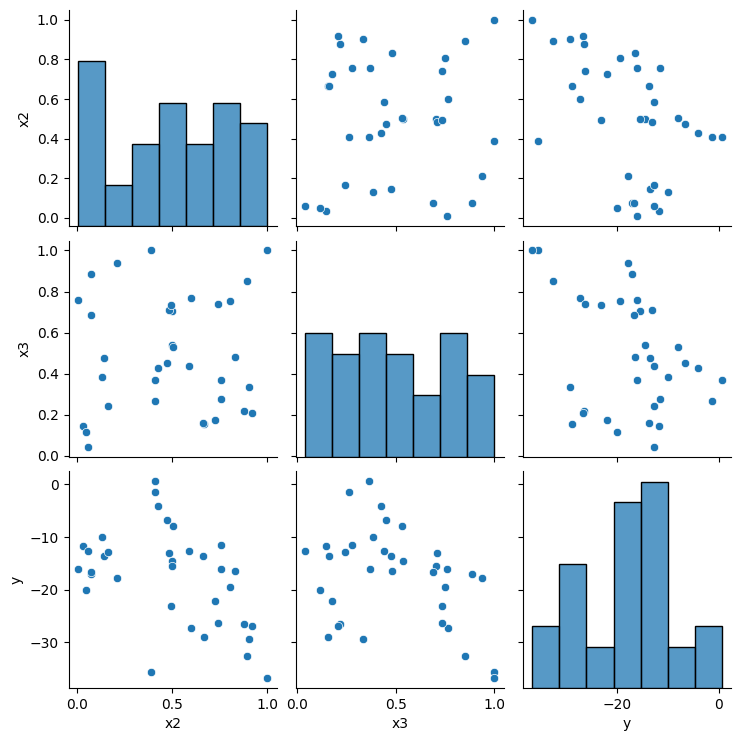

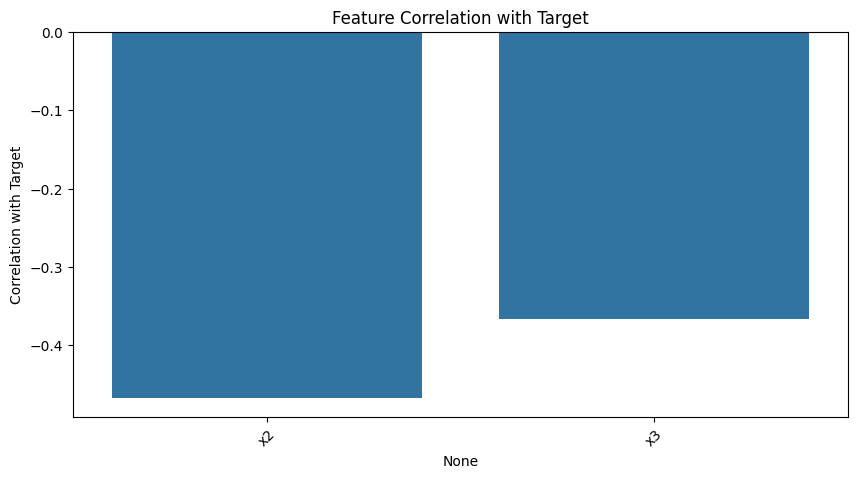

GP kernel=
3.16**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=0.01)
Next acquisition point (UCB): [0.36842105 0.36842105]
queryPoint=[0.36842105 0.36842105]
queryPoint (formatted)=0.368421-0.368421


GP kernel=
3.16**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.01)
Next acquisition point (UCB): [0.36842105 0.42105263 0.42105263 0.42105263]
queryPoint=[0.36842105 0.42105263 0.42105263 0.42105263]
queryPoint (formatted)=0.368421-0.421053-0.421053-0.421053


In [10]:
f4 = BBfcn(4)
print(f4)
f4.plot_feature_correlations()
f4.plot_correlations_with_cross_terms()

# dimension reduction for f4()
class f4dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1","x4"],inplace=True)

tr = f4dimRedTransform()
f4_dimRed = BBfcn(4)
f4_dimRed.transform(tr)
print(f4_dimRed)
f4_dimRed.plot_feature_correlations()
# f4_dimRed.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 20)) * Matern(length_scale=[1,1],nu=2.5) + WhiteKernel(noise_level=0.01)
f4_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

# Full dimensional GP for f4()
kernel = C(10, (0.001, 20)) * Matern(length_scale=[1,1,1,1],nu=2.5) + WhiteKernel(noise_level=0.01)
f4.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)


------------ function_5 --------------
       x1     x2     x3     x4         y
0   0.191  0.038  0.607  0.415    64.443
1   0.759  0.537  0.656  0.360    18.301
2   0.438  0.804  0.210  0.151     0.113
3   0.706  0.534  0.264  0.482     4.211
4   0.836  0.194  0.664  0.786   258.371
5   0.683  0.119  0.829  0.568    78.434
6   0.554  0.667  0.324  0.815    57.572
7   0.352  0.322  0.117  0.473   109.572
8   0.154  0.729  0.423  0.443     8.848
9   0.463  0.630  0.108  0.958   233.224
10  0.677  0.359  0.480  0.073    24.423
11  0.584  0.147  0.348  0.429    64.420
12  0.307  0.317  0.623  0.095    63.477
13  0.511  0.818  0.729  0.112    79.729
14  0.439  0.774  0.378  0.934   355.807
15  0.224  0.846  0.879  0.879  1088.860
16  0.725  0.480  0.089  0.760    28.867
17  0.355  0.640  0.418  0.123    45.182
18  0.120  0.863  0.643  0.850   431.613
19  0.127  0.153  0.770  0.191     9.972
20  0.255  0.962  1.000  0.999  3964.329
21  1.000  0.000  1.000  1.000  4440.523
22  1.000  1.000  

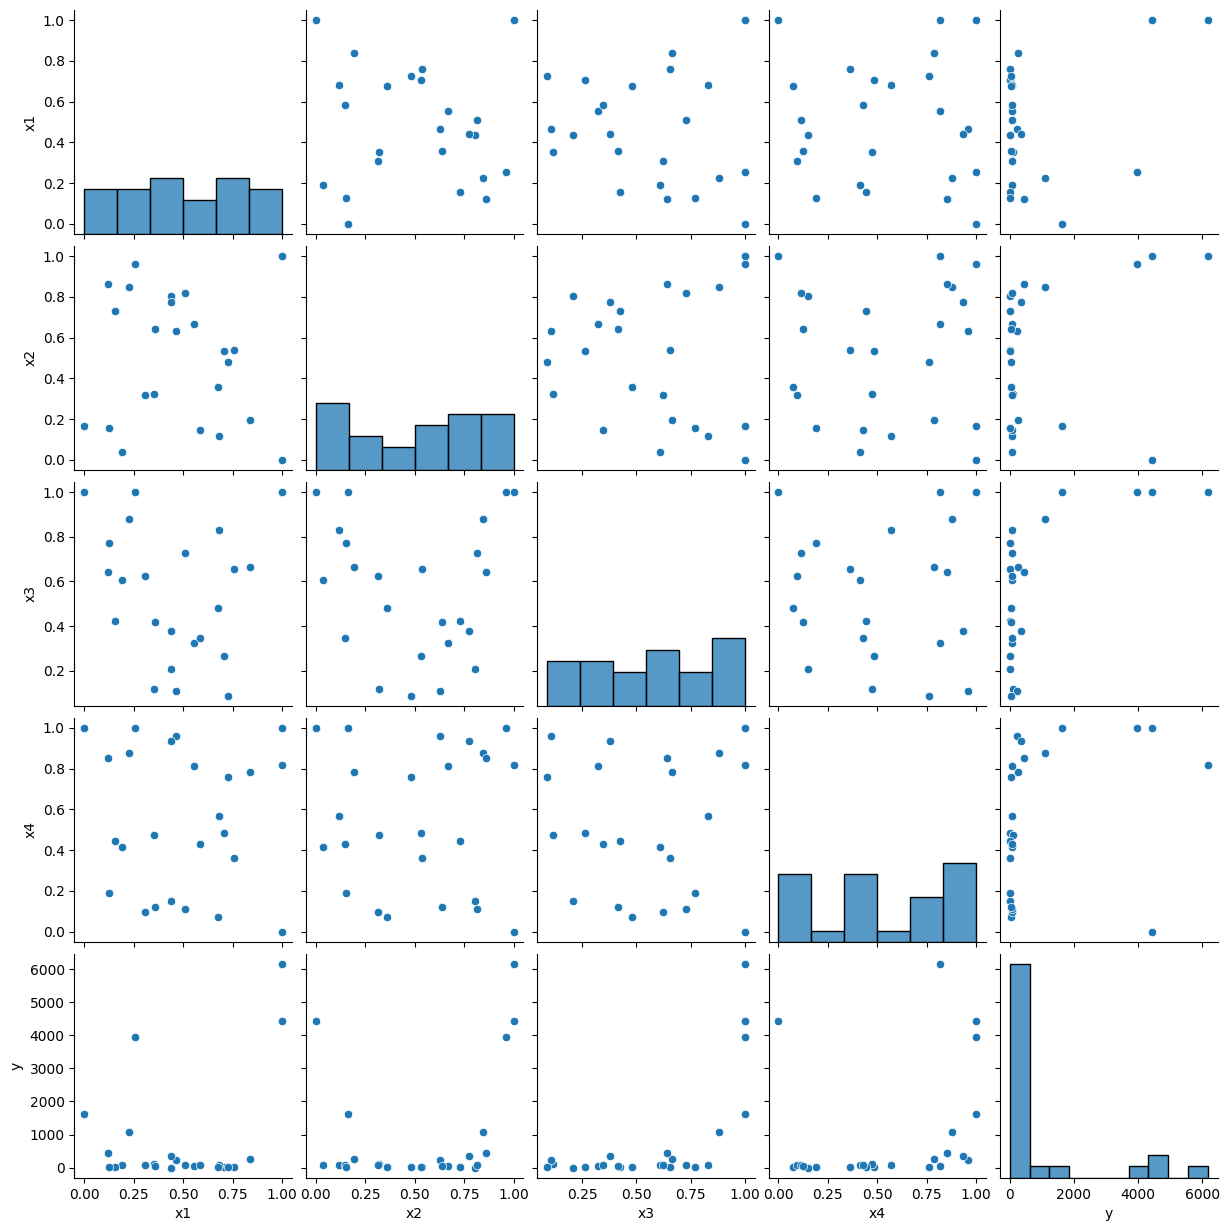

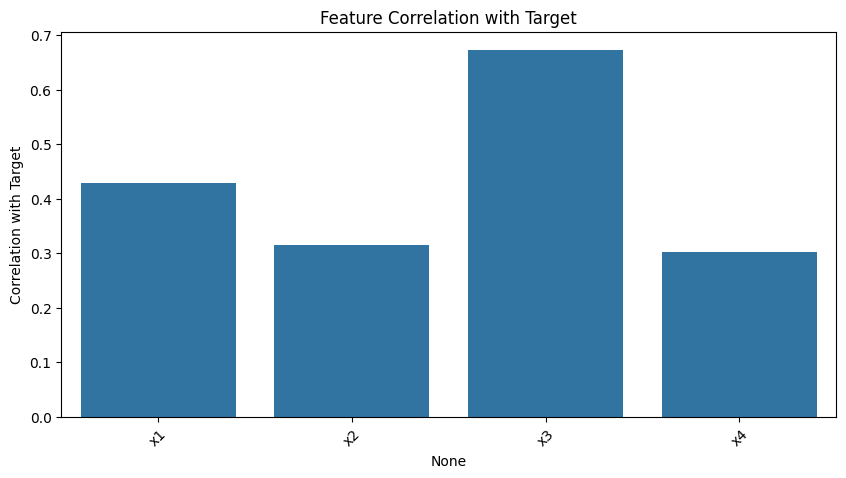

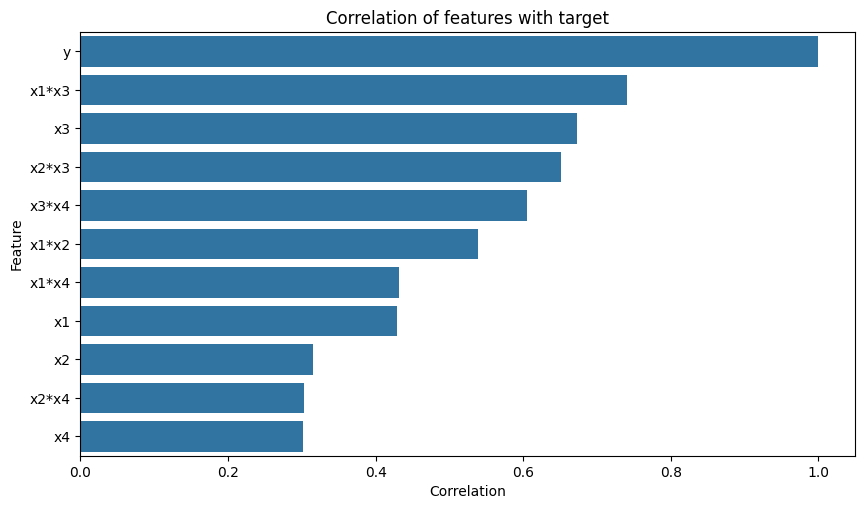

------------ function_5 --------------
       x1     x3         y
0   0.191  0.607    64.443
1   0.759  0.656    18.301
2   0.438  0.210     0.113
3   0.706  0.264     4.211
4   0.836  0.664   258.371
5   0.683  0.829    78.434
6   0.554  0.324    57.572
7   0.352  0.117   109.572
8   0.154  0.423     8.848
9   0.463  0.108   233.224
10  0.677  0.480    24.423
11  0.584  0.348    64.420
12  0.307  0.623    63.477
13  0.511  0.729    79.729
14  0.439  0.378   355.807
15  0.224  0.879  1088.860
16  0.725  0.089    28.867
17  0.355  0.418    45.182
18  0.120  0.643   431.613
19  0.127  0.770     9.972
20  0.255  1.000  3964.329
21  1.000  1.000  4440.523
22  1.000  1.000  6169.418
23  0.000  1.000  1618.709
24  1.000  1.000  4440.523

Max of 6169.41816686016 realized at row
     x1   x3         y
22  1.0  1.0  6169.418



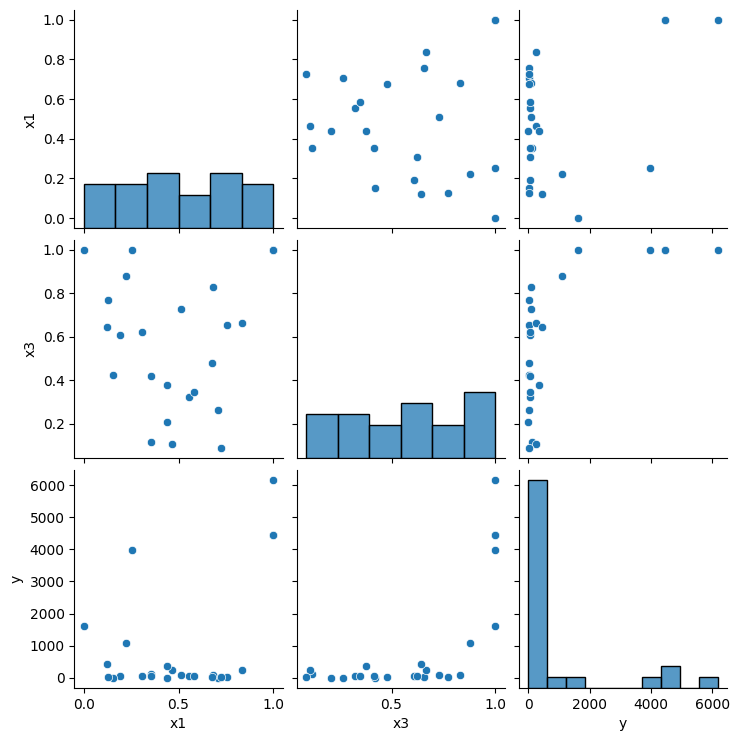

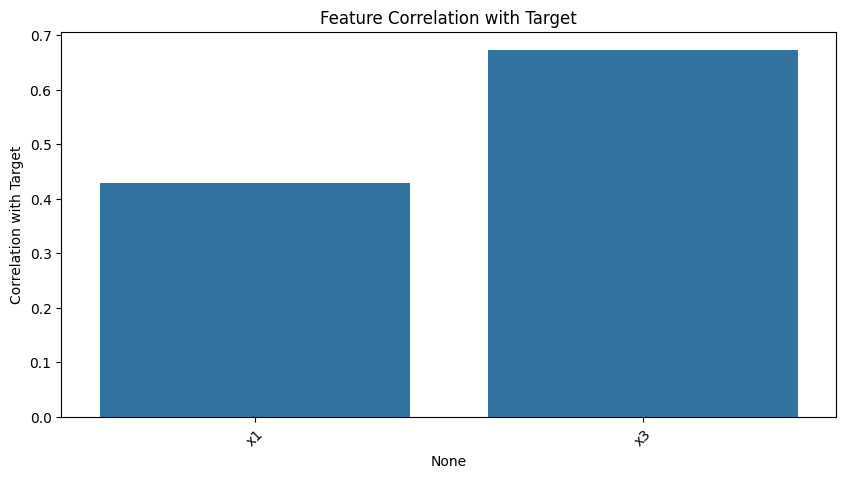

GP kernel=
3.16**2 * Matern(length_scale=[0.01, 0.01], nu=2.5) + WhiteKernel(noise_level=10)
Next acquisition point (UCB): [1. 1.]
queryPoint=[1. 1.]
queryPoint (formatted)=1.000000-1.000000


GP kernel=
3.16**2 * Matern(length_scale=[0.01, 0.01, 0.01, 0.01], nu=2.5) + WhiteKernel(noise_level=10)
Next acquisition point (UCB): [1. 1. 1. 1.]
queryPoint=[1. 1. 1. 1.]
queryPoint (formatted)=1.000000-1.000000-1.000000-1.000000


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



In [11]:
f5 = BBfcn(5)
print(f5)
f5.plot_feature_correlations()
f5.plot_correlations_with_cross_terms()

# dimension reduction for f5()
class f5dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x2","x4"],inplace=True)

tr = f5dimRedTransform()
f5_dimRed = BBfcn(5)
f5_dimRed.transform(tr)
print(f5_dimRed)
f5_dimRed.plot_feature_correlations()
# f4_dimRed.plot_correlations_with_cross_terms()
kernel = C(10, (0.001, 10000)) * Matern(length_scale=[0.01,0.01],nu=2.5) + WhiteKernel(noise_level=10.0)
f5_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=2)

# Full dimensional GP for f5()
kernel = C(10, (0.001, 10000)) * Matern(length_scale=[0.01,0.01,0.01,0.01],nu=2.5) + WhiteKernel(noise_level=10.0)
f5.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=2)


------------ function_6 --------------
       x1     x2     x3     x4     x5      y
0   0.728  0.155  0.733  0.694  0.056 -0.714
1   0.242  0.844  0.578  0.679  0.502 -1.210
2   0.730  0.748  0.680  0.357  0.671 -1.672
3   0.771  0.114  0.047  0.648  0.274 -1.536
4   0.619  0.332  0.187  0.756  0.329 -0.829
5   0.785  0.911  0.708  0.959  0.005 -1.247
6   0.145  0.897  0.896  0.726  0.236 -1.234
7   0.945  0.288  0.979  0.962  0.598 -1.694
8   0.126  0.863  0.029  0.247  0.751 -2.571
9   0.758  0.356  0.017  0.434  0.112 -1.309
10  0.537  0.309  0.412  0.388  0.523 -1.145
11  0.958  0.236  0.099  0.157  0.071 -1.913
12  0.629  0.803  0.811  0.046  0.111 -1.623
13  0.022  0.428  0.836  0.489  0.511 -1.357
14  0.439  0.699  0.427  0.109  0.878 -2.018
15  0.259  0.794  0.642  0.197  0.593 -1.703
16  0.432  0.716  0.342  0.705  0.615 -1.294
17  0.783  0.536  0.443  0.860  0.010 -0.936
18  0.922  0.932  0.415  0.595  0.736 -2.156
19  0.127  0.291  0.065  0.681  0.893 -1.747
20  0.994  0.211

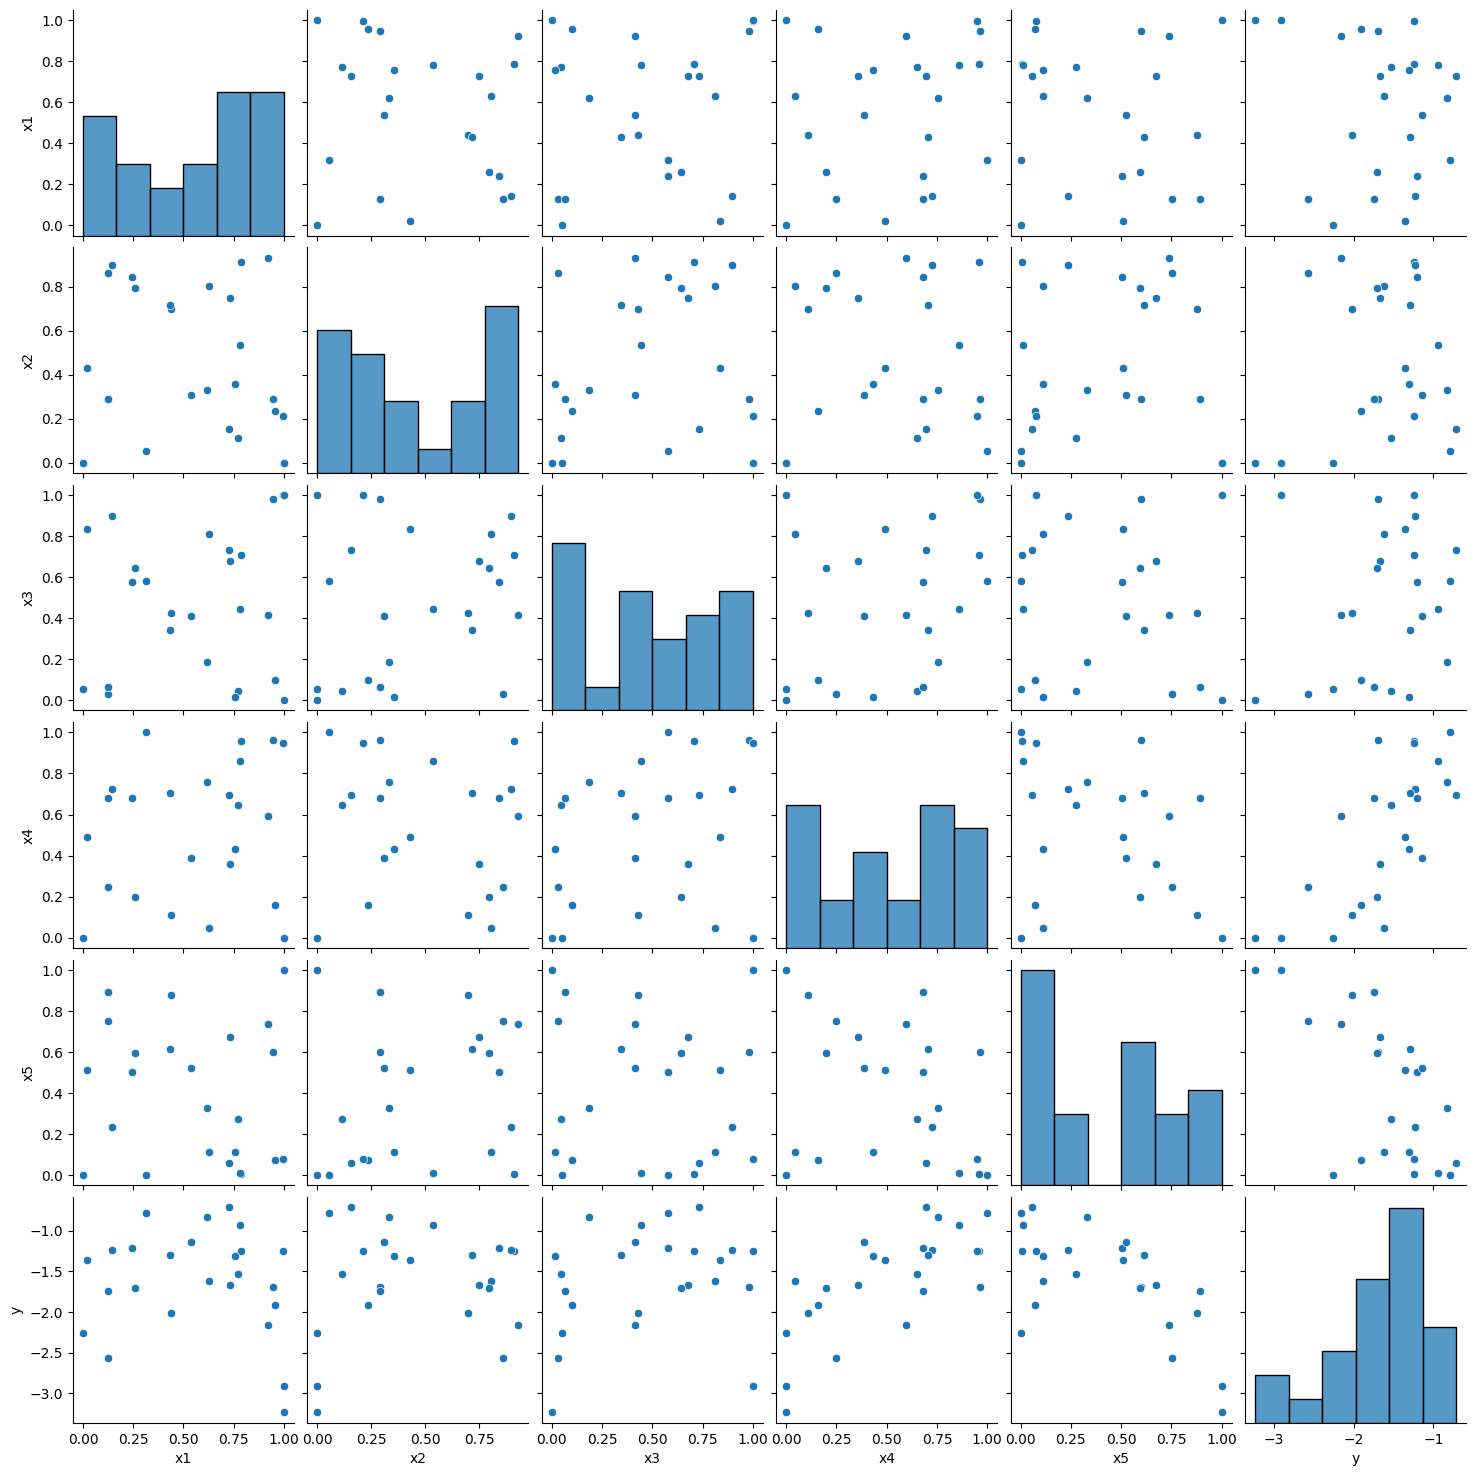

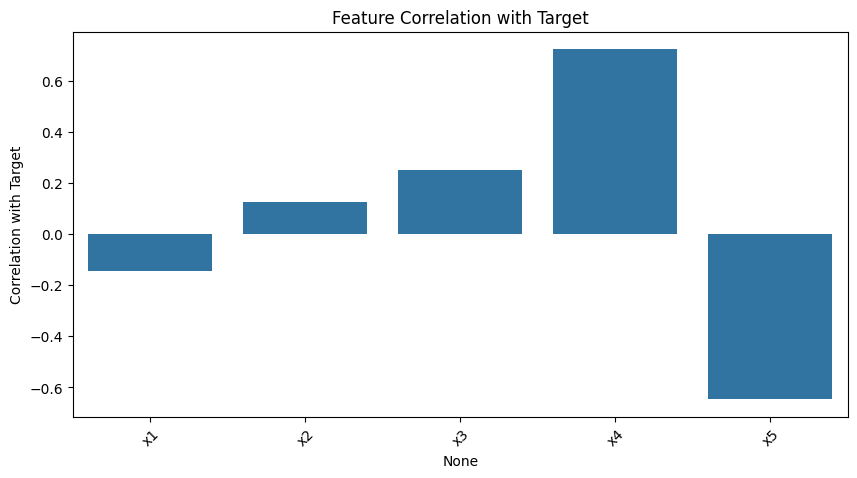

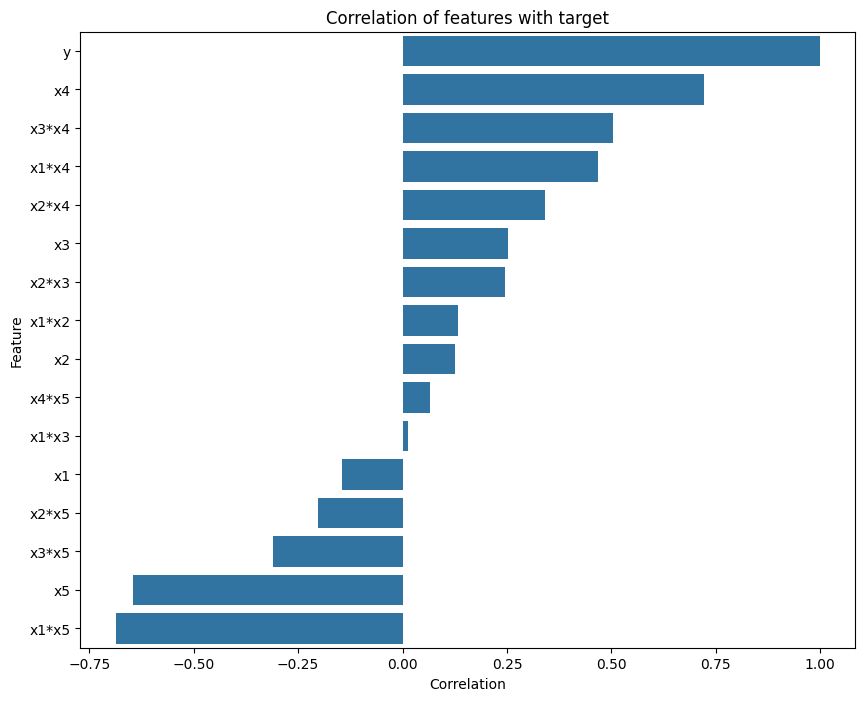

------------ function_6 --------------
       x4     x5      y
0   0.694  0.056 -0.714
1   0.679  0.502 -1.210
2   0.357  0.671 -1.672
3   0.648  0.274 -1.536
4   0.756  0.329 -0.829
5   0.959  0.005 -1.247
6   0.726  0.236 -1.234
7   0.962  0.598 -1.694
8   0.247  0.751 -2.571
9   0.434  0.112 -1.309
10  0.388  0.523 -1.145
11  0.157  0.071 -1.913
12  0.046  0.111 -1.623
13  0.489  0.511 -1.357
14  0.109  0.878 -2.018
15  0.197  0.593 -1.703
16  0.705  0.615 -1.294
17  0.860  0.010 -0.936
18  0.595  0.736 -2.156
19  0.681  0.893 -1.747
20  0.947  0.077 -1.245
21  1.000  0.000 -0.785
22  0.000  1.000 -2.910
23  0.000  0.000 -2.256
24  0.000  1.000 -3.235

Max of -0.7142649478202404 realized at row
      x4     x5      y
0  0.694  0.056 -0.714



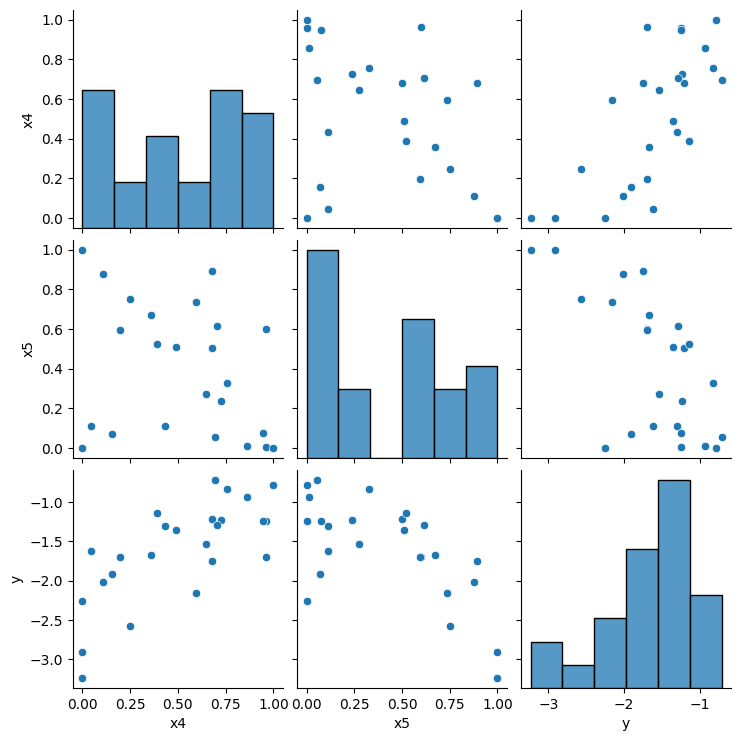

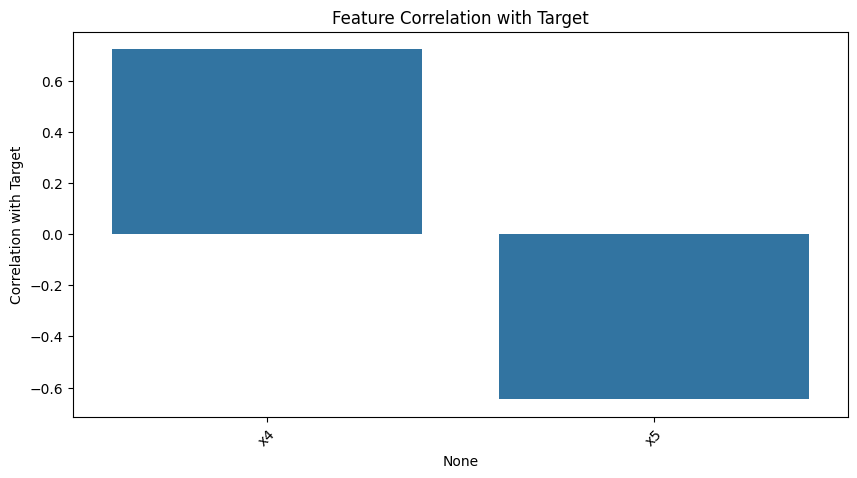

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=1)
Next acquisition point (UCB): [1. 0.]
queryPoint=[1. 0.]
queryPoint (formatted)=1.000000-0.000000


GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=1)
Next acquisition point (UCB): [0.47368421 0.36842105 1.         1.         0.        ]
queryPoint=[0.47368421 0.36842105 1.         1.         0.        ]
queryPoint (formatted)=0.473684-0.368421-1.000000-1.000000-0.000000


In [12]:
f6 = BBfcn(6)
print(f6)
f6.plot_feature_correlations()
f6.plot_correlations_with_cross_terms()

# dimension reduction for f6()
class f6dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1","x2","x3"],inplace=True)

f6_dimRed = BBfcn(6)
f6_dimRed.transform(f6dimRedTransform())
print(f6_dimRed)
f6_dimRed.plot_feature_correlations()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1.0)
f6_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

#full dimensional GP for f6()
kernel = C(10, (0.001, 10)) * Matern(length_scale=[0.2,0.2,0.2,0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1.0)
f6.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)



------------ function_7 --------------
       x1     x2     x3     x4     x5     x6          y
0   0.273  0.324  0.897  0.833  0.154  0.796  6.044e-01
1   0.543  0.925  0.342  0.646  0.718  0.343  5.628e-01
2   0.091  0.662  0.066  0.259  0.963  0.640  7.503e-03
3   0.119  0.615  0.906  0.855  0.414  0.585  6.142e-02
4   0.630  0.838  0.680  0.732  0.527  0.348  2.730e-01
5   0.765  0.256  0.609  0.218  0.323  0.096  8.375e-02
6   0.058  0.492  0.247  0.218  0.420  0.731  1.365e+00
7   0.195  0.079  0.555  0.171  0.015  0.107  9.264e-02
8   0.642  0.837  0.022  0.101  0.683  0.692  1.787e-02
9   0.790  0.196  0.576  0.074  0.259  0.051  3.356e-02
10  0.528  0.457  0.360  0.362  0.817  0.637  7.352e-02
11  0.723  0.012  0.064  0.165  0.079  0.360  2.063e-01
12  0.076  0.335  0.133  0.608  0.918  0.822  8.826e-03
13  0.942  0.377  0.486  0.229  0.083  0.712  2.684e-01
14  0.149  0.034  0.729  0.316  0.022  0.517  6.115e-01
15  0.817  0.548  0.103  0.124  0.728  0.450  1.480e-02
16  0.418

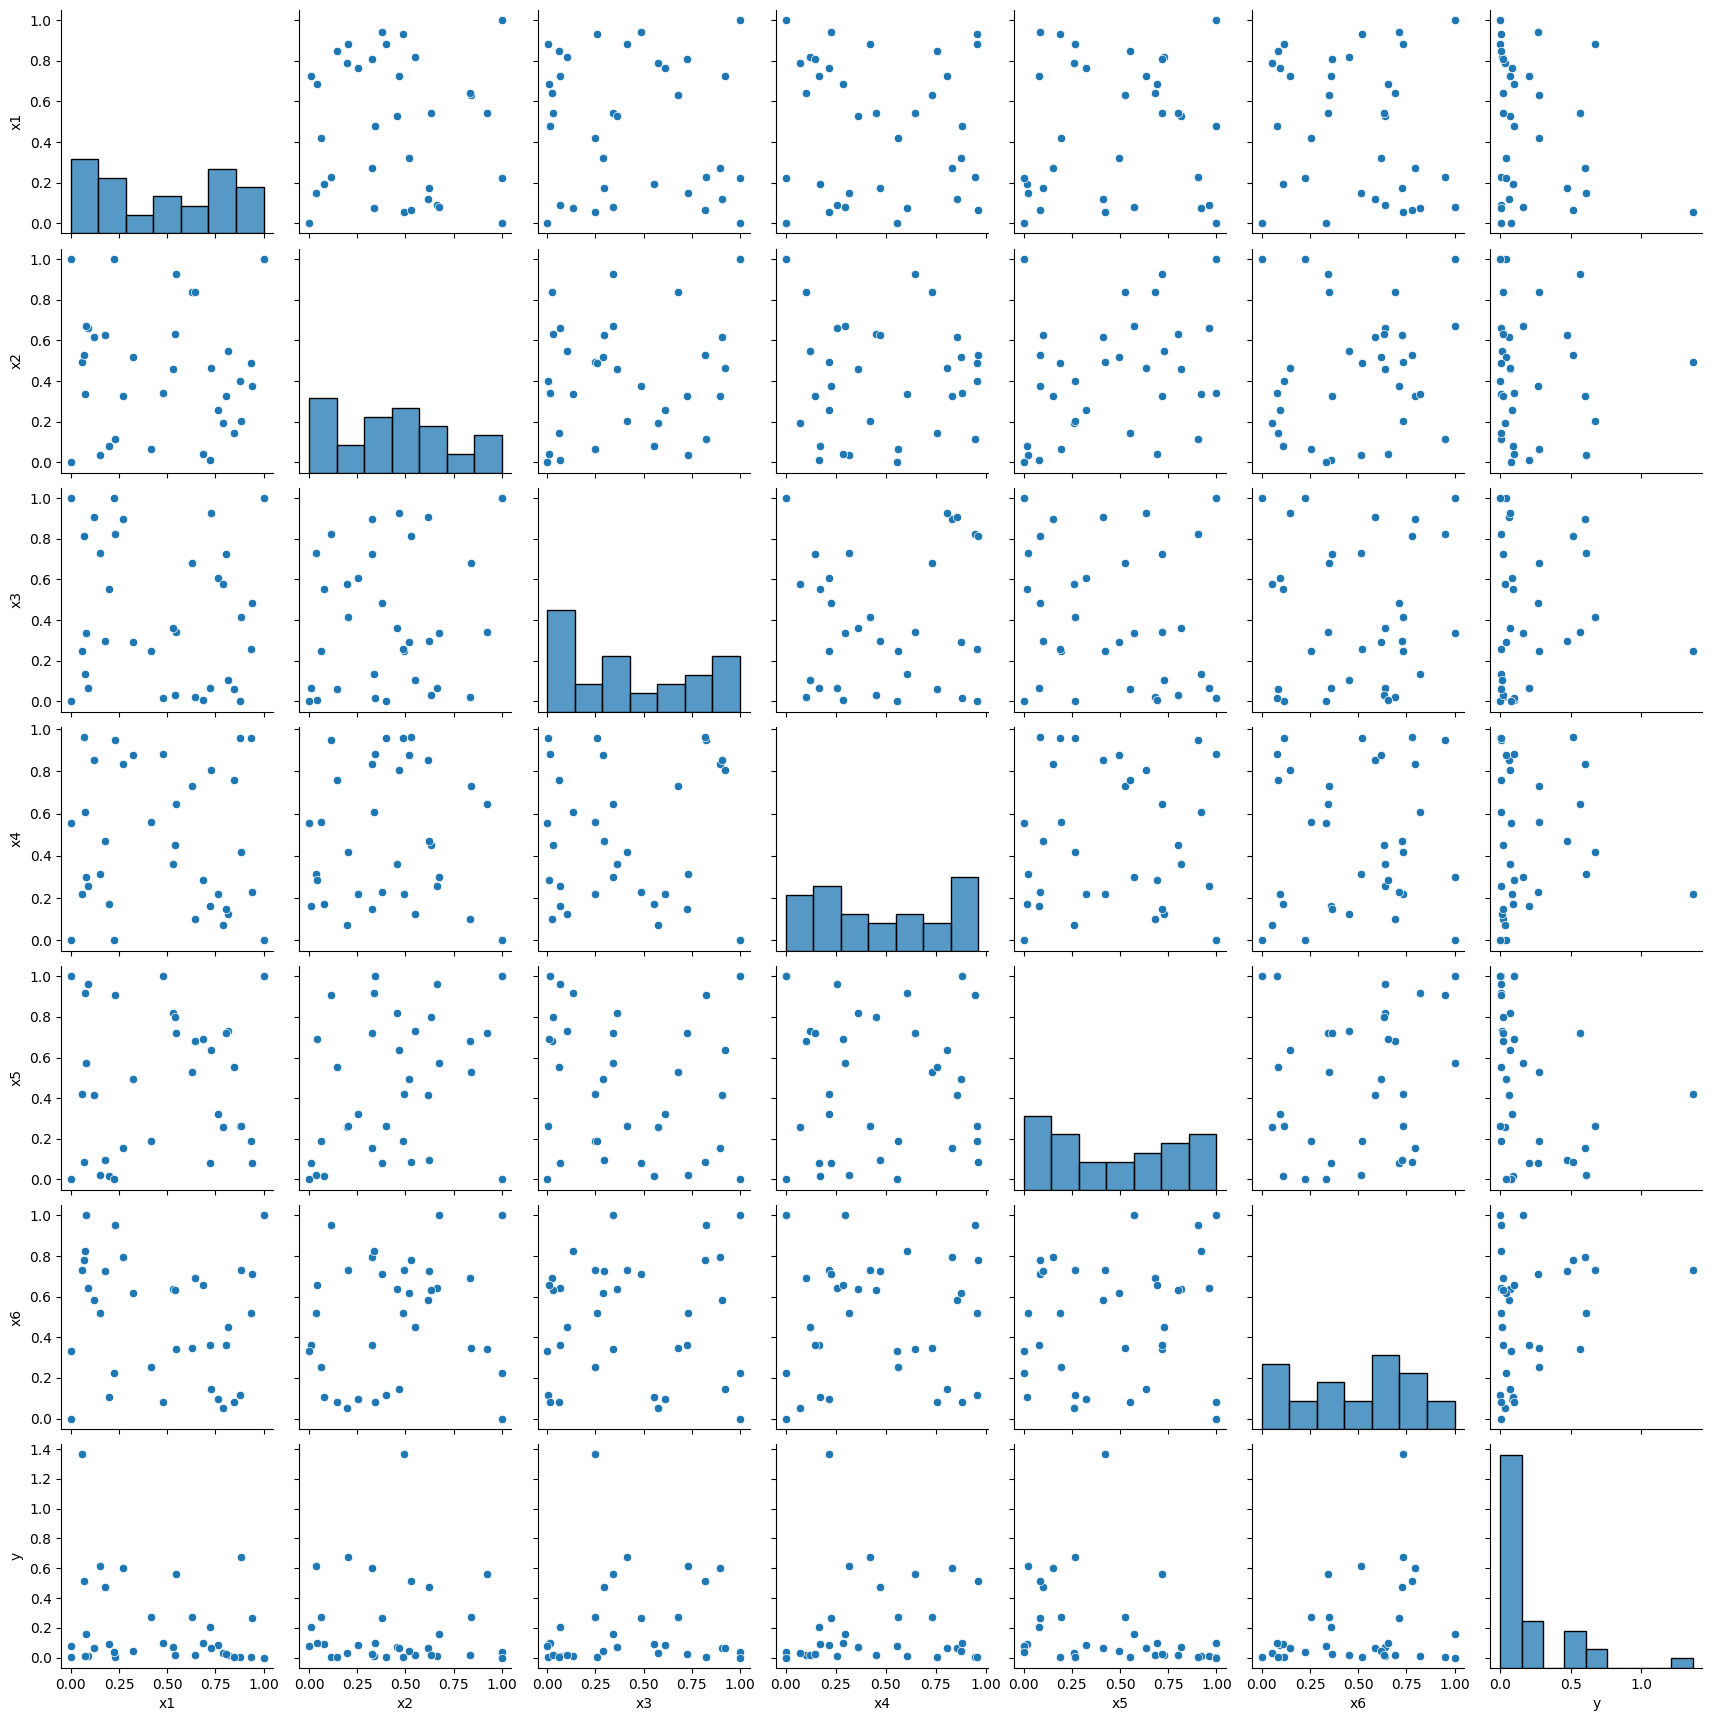

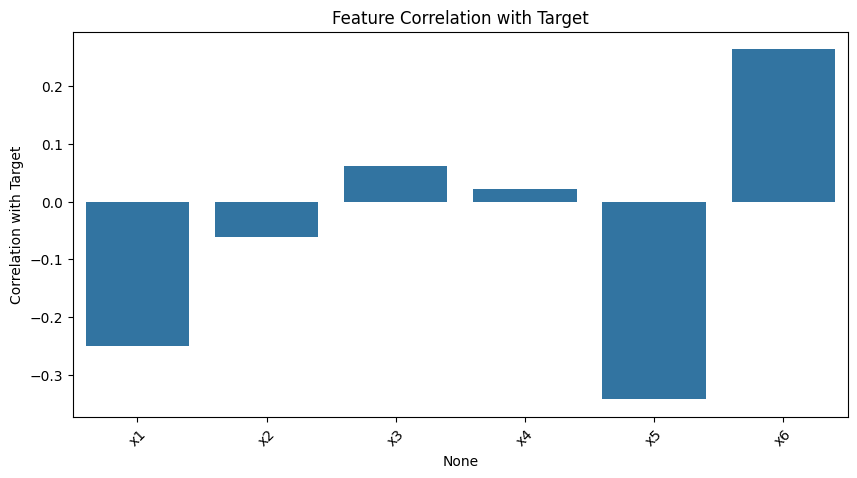

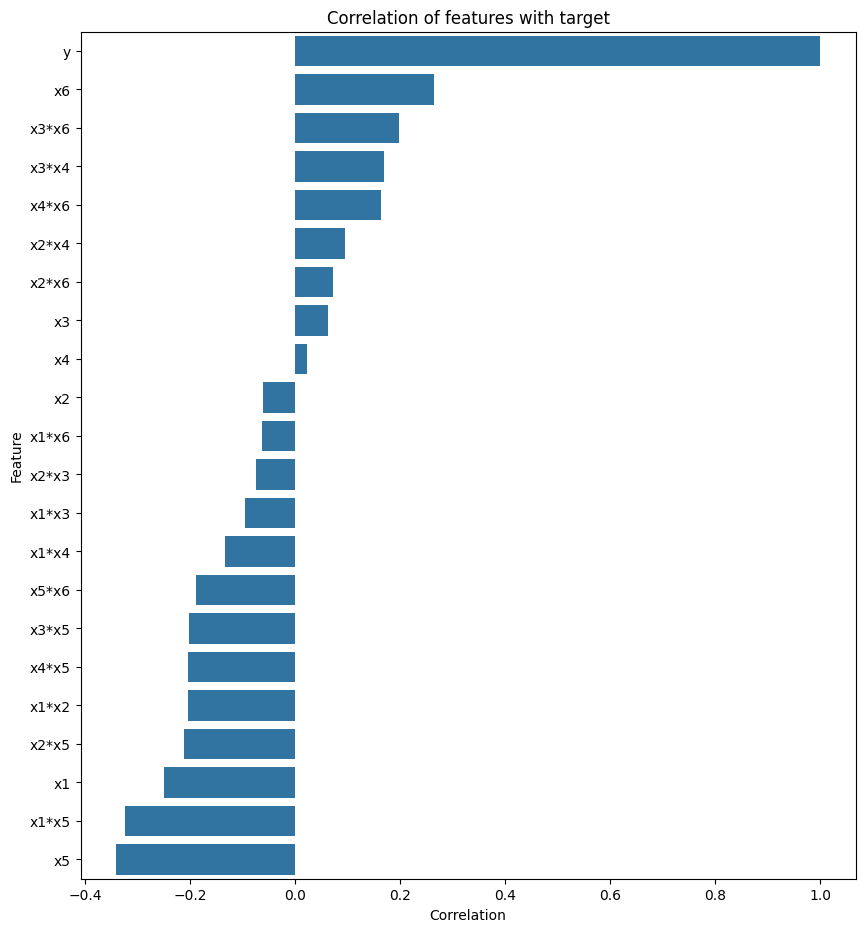

------------ function_7 --------------
       x5     x6          y
0   0.154  0.796  6.044e-01
1   0.718  0.343  5.628e-01
2   0.963  0.640  7.503e-03
3   0.414  0.585  6.142e-02
4   0.527  0.348  2.730e-01
5   0.323  0.096  8.375e-02
6   0.420  0.731  1.365e+00
7   0.015  0.107  9.264e-02
8   0.683  0.692  1.787e-02
9   0.259  0.051  3.356e-02
10  0.817  0.637  7.352e-02
11  0.079  0.360  2.063e-01
12  0.918  0.822  8.826e-03
13  0.083  0.712  2.684e-01
14  0.022  0.517  6.115e-01
15  0.728  0.450  1.480e-02
16  0.192  0.255  2.749e-01
17  0.635  0.143  6.676e-02
18  0.495  0.619  4.212e-02
19  0.265  0.115  2.701e-03
20  0.799  0.634  1.821e-02
21  0.905  0.951  7.016e-03
22  0.692  0.656  1.005e-01
23  0.098  0.728  4.754e-01
24  0.265  0.731  6.751e-01
25  0.087  0.778  5.165e-01
26  0.190  0.520  3.777e-03
27  0.552  0.081  3.134e-03
28  0.719  0.363  2.134e-02
29  0.999  0.080  9.541e-02
30  0.575  1.000  1.604e-01
31  0.000  0.333  8.051e-02
32  1.000  0.000  6.143e-03
33  0.000

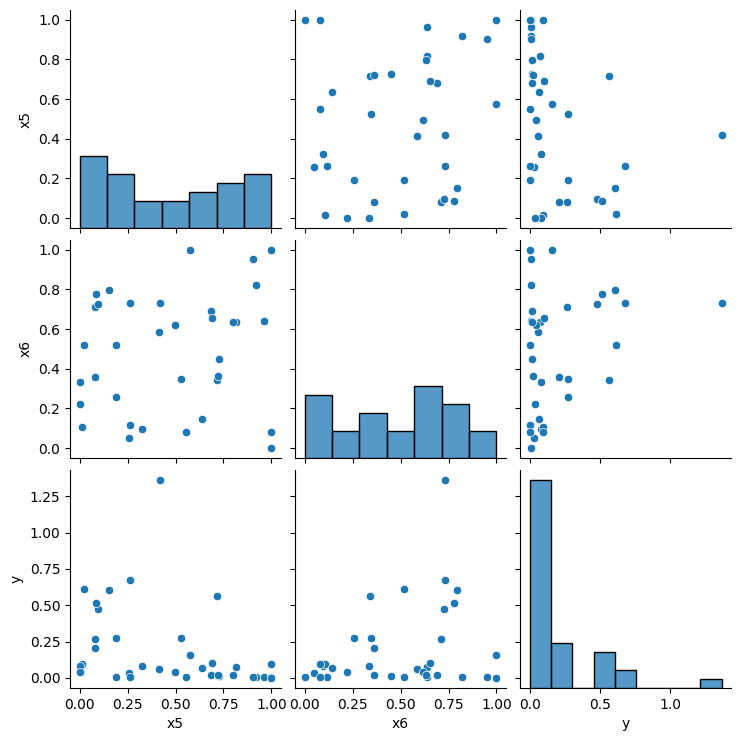

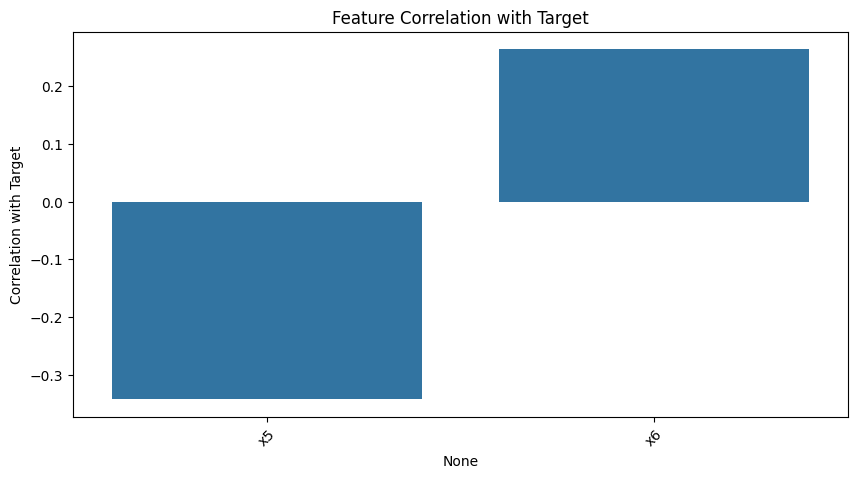

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.0001)
Next acquisition point (UCB): [0.05263158 0.        ]
queryPoint=[0.05263158 0.        ]
queryPoint (formatted)=0.052632-0.000000


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packa

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.0001)
Next acquisition point (UCB): [0.         0.42857143 0.28571429 0.14285714 0.42857143 0.71428571]
queryPoint=[0.         0.42857143 0.28571429 0.14285714 0.42857143 0.71428571]
queryPoint (formatted)=0.000000-0.428571-0.285714-0.142857-0.428571-0.714286


In [13]:
f7 = BBfcn(7)
print(f7)
f7.plot_feature_correlations()
f7.plot_correlations_with_cross_terms()

f7_dimRed = BBfcn(7)
# dimension reduction for f7()
class f7dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x1","x2","x3","x4"],inplace=True)
f7_dimRed.transform(f7dimRedTransform())
print(f7_dimRed)
f7_dimRed.plot_feature_correlations()
kernel = C(10, (0.00001, 1)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-4)
f7_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

#full dimensional GP for f7()
kernel = C(10, (0.00001, 1)) * Matern(length_scale=[0.2,0.2,0.2,0.2,0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-4)
f7.nextPointBayesianOptim(kernel,numgrid=15,acqFcn="UCB",beta=0.5)

------------ function_8 --------------
       x1     x2     x3     x4     x5     x6     x7     x8      y
0   0.605  0.292  0.908  0.356  0.202  0.575  0.310  0.734  7.399
1   0.178  0.566  0.995  0.210  0.320  0.708  0.635  0.107  7.005
2   0.009  0.812  0.521  0.076  0.265  0.092  0.592  0.367  8.459
3   0.506  0.654  0.363  0.178  0.094  0.197  0.756  0.292  8.284
4   0.360  0.249  0.496  0.709  0.115  0.289  0.557  0.594  8.606
5   0.779  0.003  0.338  0.520  0.821  0.537  0.551  0.660  8.542
6   0.909  0.062  0.238  0.767  0.132  0.990  0.688  0.742  7.327
7   0.586  0.881  0.745  0.546  0.010  0.749  0.231  0.098  7.300
8   0.761  0.855  0.382  0.337  0.690  0.310  0.631  0.042  7.958
9   0.985  0.700  0.999  0.180  0.580  0.231  0.491  0.314  5.592
10  0.112  0.438  0.597  0.593  0.227  0.410  0.921  0.675  7.855
11  0.792  0.576  0.695  0.283  0.137  0.279  0.843  0.625  6.792
12  0.144  0.937  0.232  0.009  0.415  0.409  0.554  0.206  8.977
13  0.770  0.459  0.559  0.695  0.503

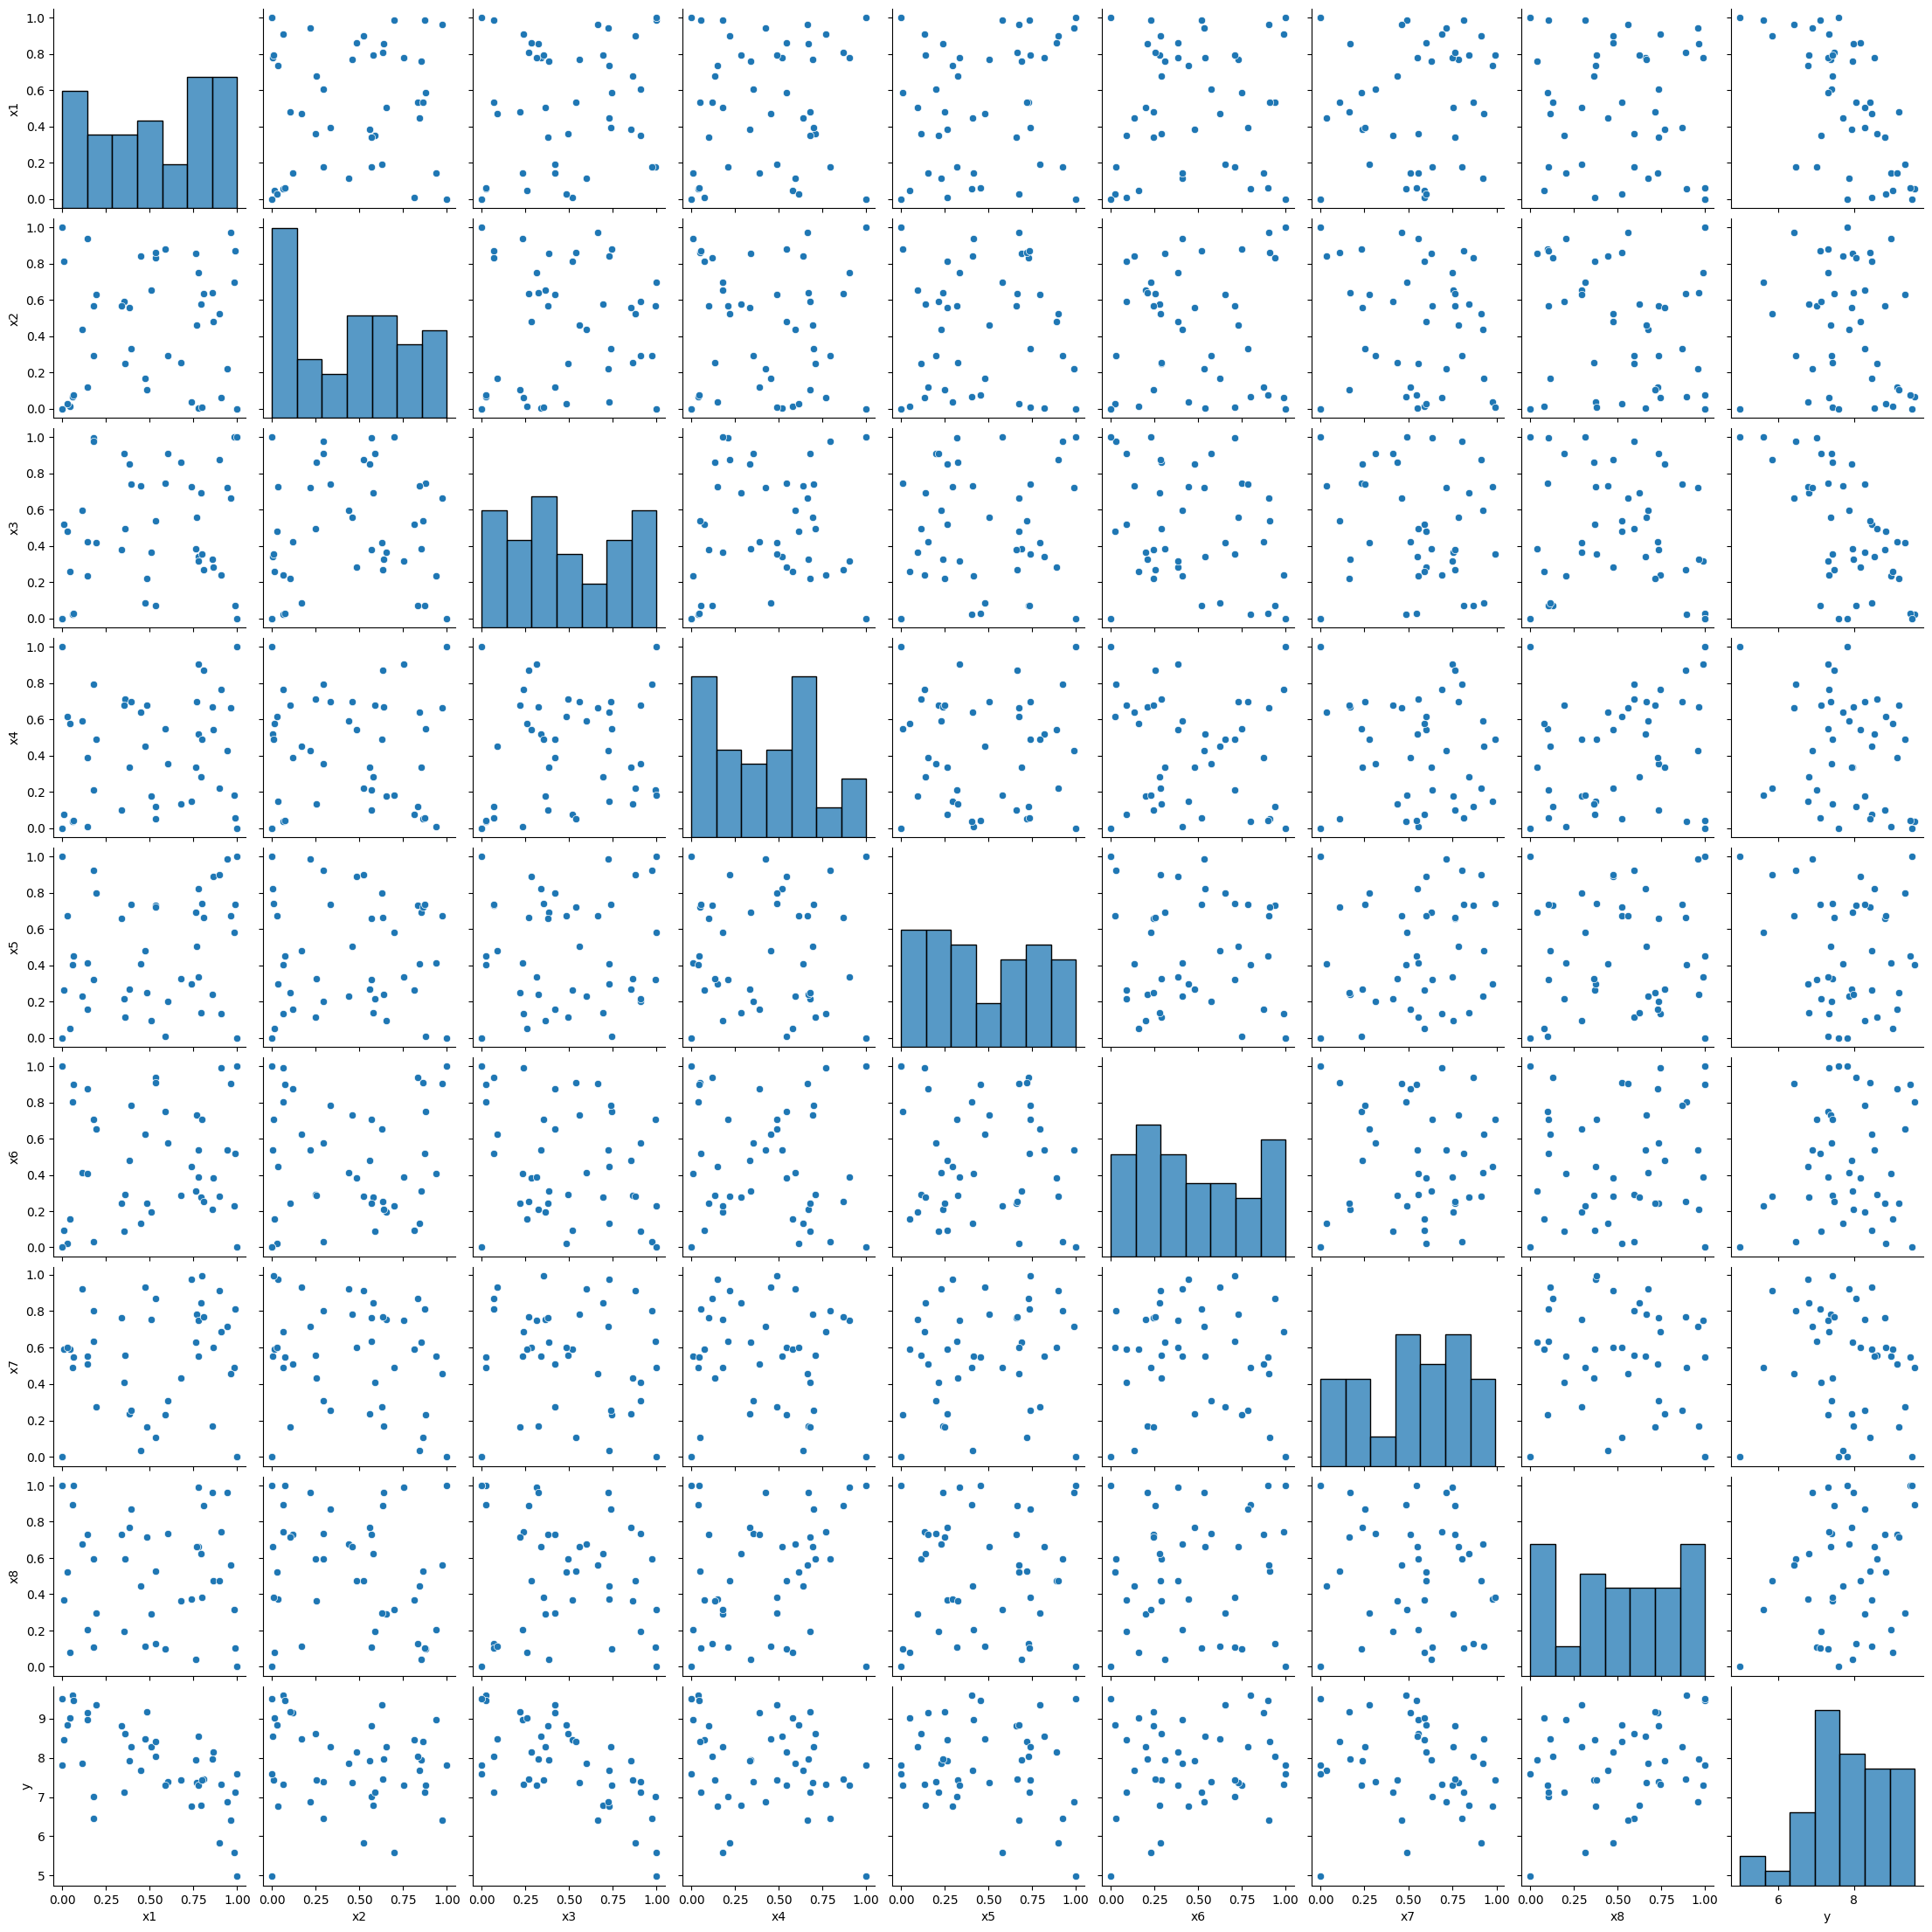

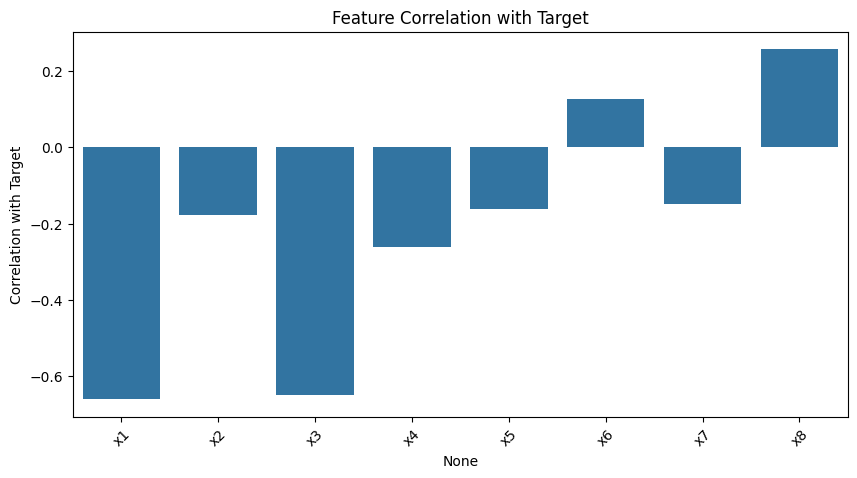

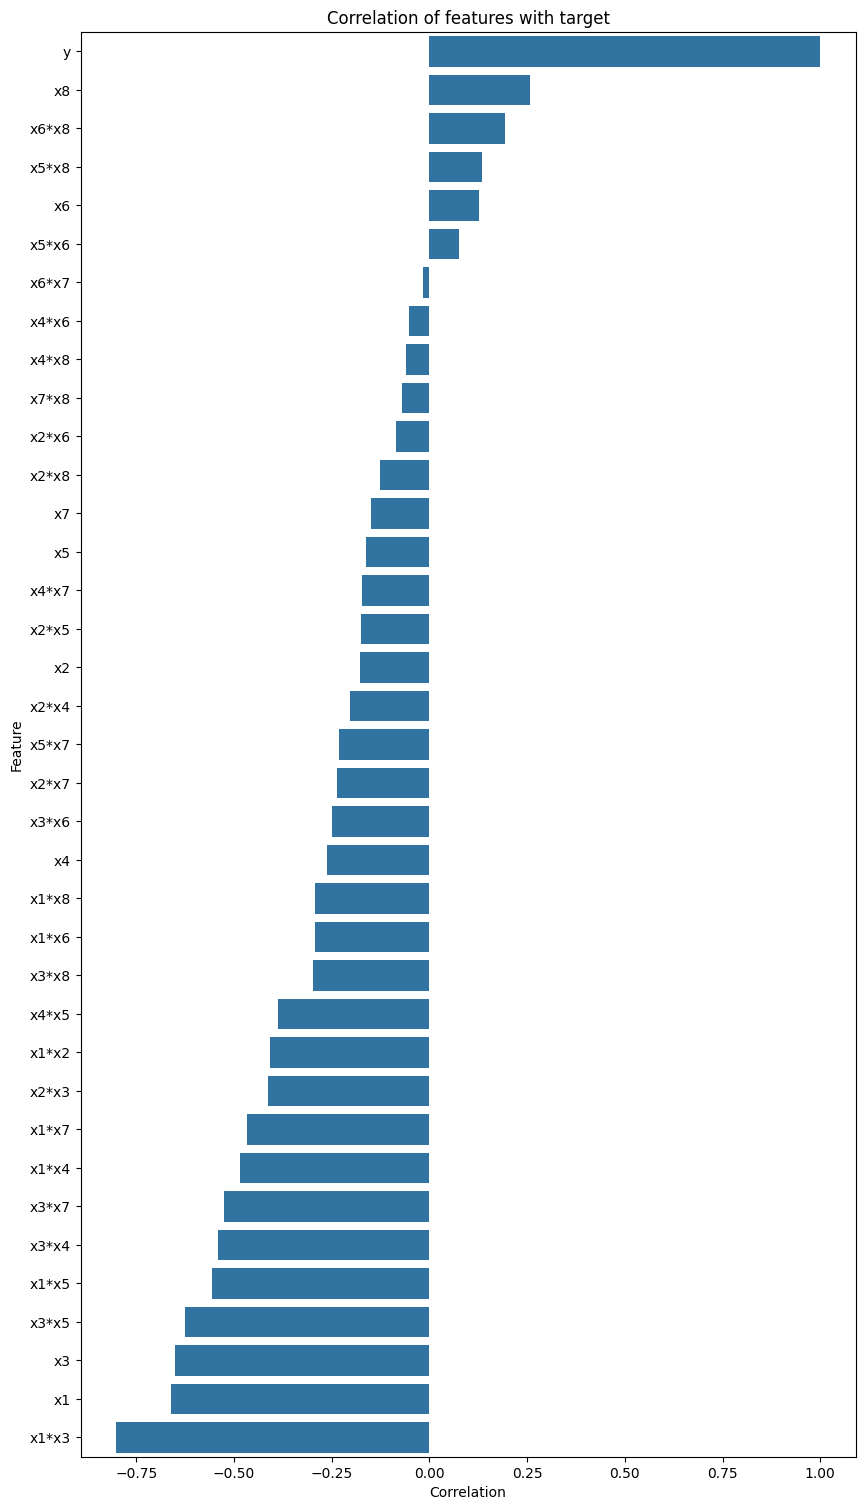

------------ function_8 --------------
       x1     x3      y
0   0.605  0.908  7.399
1   0.178  0.995  7.005
2   0.009  0.521  8.459
3   0.506  0.363  8.284
4   0.360  0.496  8.606
5   0.779  0.338  8.542
6   0.909  0.238  7.327
7   0.586  0.745  7.300
8   0.761  0.382  7.958
9   0.985  0.999  5.592
10  0.112  0.597  7.855
11  0.792  0.695  6.792
12  0.144  0.232  8.977
13  0.770  0.559  7.379
14  0.056  0.023  9.598
15  0.862  0.282  8.160
16  0.352  0.909  7.132
17  0.736  0.728  6.768
18  0.680  0.862  7.434
19  0.044  0.258  9.013
20  0.778  0.314  7.311
21  0.899  0.877  5.841
22  0.145  0.421  9.142
23  0.339  0.377  8.818
24  0.176  0.976  6.452
25  0.029  0.481  8.831
26  0.193  0.417  9.344
27  0.943  0.721  6.888
28  0.533  0.071  8.042
29  0.447  0.730  7.692
30  0.382  0.853  7.924
31  0.533  0.538  8.422
32  0.395  0.741  8.278
33  0.986  0.070  7.113
34  0.965  0.664  6.403
35  0.472  0.086  8.473
36  0.856  0.326  7.978
37  0.810  0.270  7.461
38  0.796  0.356  7.437
3

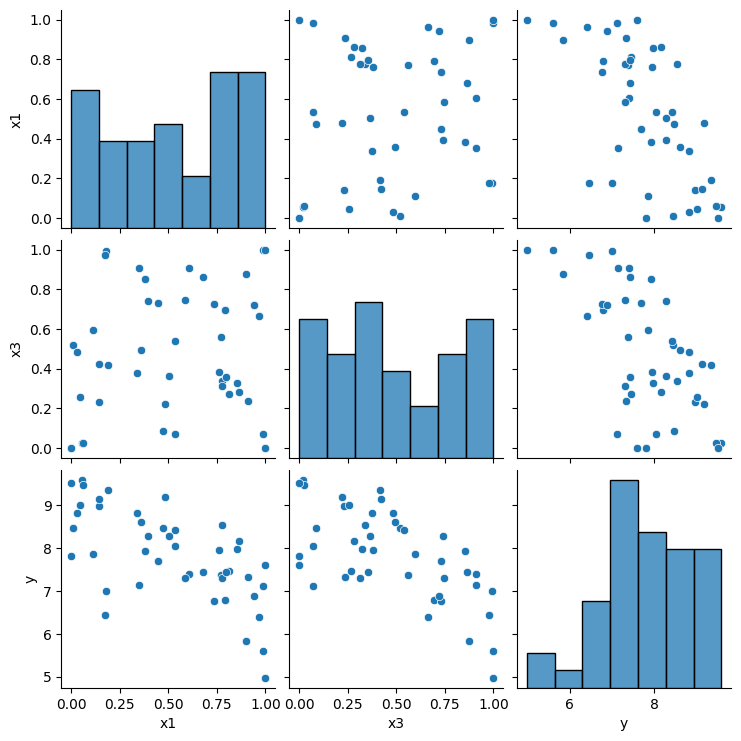

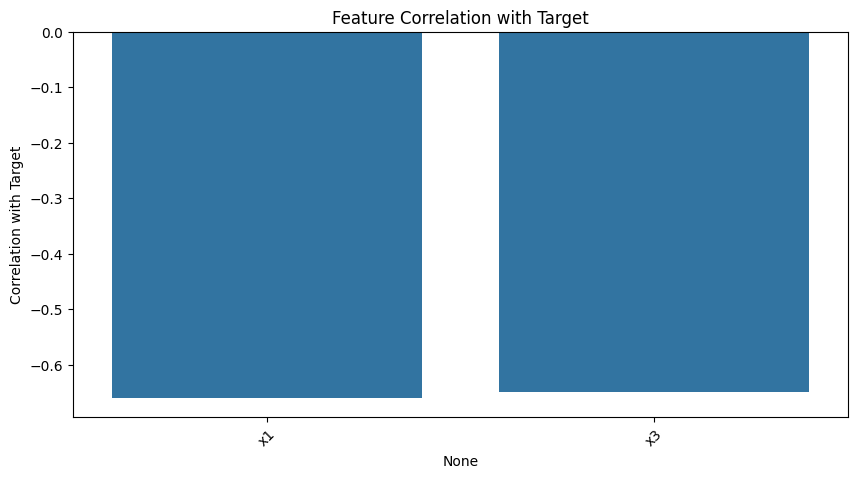

GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [0.10526316 0.15789474]
queryPoint=[0.10526316 0.15789474]
queryPoint (formatted)=0.105263-0.157895


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 7 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



GP kernel=
3.16**2 * Matern(length_scale=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=0.1)
Next acquisition point (UCB): [0.14285714 0.14285714 0.14285714 0.         1.         0.57142857
 0.14285714 0.        ]
queryPoint=[0.14285714 0.14285714 0.14285714 0.         1.         0.57142857
 0.14285714 0.        ]
queryPoint (formatted)=0.142857-0.142857-0.142857-0.000000-1.000000-0.571429-0.142857-0.000000


In [14]:
f8 = BBfcn(8)
print(f8)
f8.plot_feature_correlations()
f8.plot_correlations_with_cross_terms()

f8_dimRed = BBfcn(8)
# dimension reduction for f8()
class f8dimRedTransform(Transformation):
    def __init__(self):
        pass
    def apply(self,data):
        data.drop(columns=["x2","x4","x5","x6","x7","x8"],inplace=True)
f8_dimRed.transform(f8dimRedTransform())
print(f8_dimRed)
f8_dimRed.plot_feature_correlations()
kernel = C(10, (0.001, 100)) * Matern(length_scale=[0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-1)
f8_dimRed.nextPointBayesianOptim(kernel,numgrid=20,acqFcn="UCB",beta=0.5)

#full dimensional GP for f8()
kernel = C(10, (0.001, 100)) * Matern(length_scale=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],nu=2.5) + WhiteKernel(noise_level=1e-1)
f8.nextPointBayesianOptim(kernel,numgrid=8,acqFcn="UCB",beta=0.5)

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings

def fit_linear_and_rank_terms(X, y, fit_quadratic_terms=True):
    """
    Fit a linear model (optionally with quadratic/cross terms) and rank features by importance.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Input features
    y : np.ndarray of shape (n_samples,)
        Target values
    fit_quadratic_terms : bool, default=True
        If True, include quadratic and cross terms (degree=2)

    Returns
    -------
    model : fitted LinearRegression object
    coef_df : DataFrame with features and their coefficients, sorted by absolute value
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    n_samples, n_features = X.shape

    # Determine polynomial degree
    degree = 2 if fit_quadratic_terms else 1

    # Warn if too many coefficients
    # Compute number of polynomial terms
    from math import comb
    n_terms = comb(n_features + degree, degree) if degree > 1 else n_features
    if n_terms >= n_samples:
        warnings.warn(
            f"Number of features ({n_terms}) is close to or exceeds the number of data points ({n_samples}).\n"
            "Consider setting fit_quadratic_terms=False to avoid overfitting."
        )

    # Fit polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Fit linear model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Prepare DataFrame of coefficients
    coef_df = pd.DataFrame({
        'feature': poly.get_feature_names_out([f'x{i+1}' for i in range(n_features)]),
        'coefficient': model.coef_
    })

    # Rank by absolute value
    coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

    # Print ranked terms
    print("\n=== Ranked features by absolute coefficient magnitude ===")
    print(coef_df.to_string(index=False))

    return model, coef_df

In [41]:

latest_data_dir = os.path.join(".","measurements","latest")
f_dict = read_fcns_from_disk(latest_data_dir)

for k in f_dict.keys():
    print(k)
    print("---")
    print(f_dict[k])



f_1
---
          x1        x2              y
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159249e-54
6   0.312691  0.078723  -2.089093e-91
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.997304  1.000000  3.215893e-191
11  0.653061  0.204082   5.750007e-71
12  0.000000  1.000000   0.000000e+00
13  0.000000  0.734694 -1.008828e-192
f_2
---
          x1        x2         y
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.758325  1.000000  0.240588
11  0.000000  0.00

# f_1()

In [43]:

# pick out function 1
k = "f_1"
f = f_dict[k]
print("f1 with latest data")
print(f)

row_of_max = f["y"].idxmax()
print(f"Best row so far")
print(f.loc[[row_of_max]])

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

y_train[y_train<=0] = 10e-200

print("outliers imputed")
print(y_train.T)

print("log")
y_train = np.log10(y_train)
print(y_train.T)


model, coef_df = fit_linear_and_rank_terms(X_train, y_train, fit_quadratic_terms=True)

np.random.seed(0)
# kernel = C(1, (0.001, 0.001)) * Matern(length_scale=[1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=0.0000)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.1, 0.1], nu=2.5) + WhiteKernel(noise_level=1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

print("GP kernel=")
print(gp.kernel)
#kernel_params = gp.kernel_.get_params()
#print(kernel_params["k2__length_scale"])     # Access Matern length scale

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack((X1.ravel(), X2.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 0.5  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])




f1 with latest data
          x1        x2              y
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159249e-54
6   0.312691  0.078723  -2.089093e-91
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.997304  1.000000  3.215893e-191
11  0.653061  0.204082   5.750007e-71
12  0.000000  1.000000   0.000000e+00
13  0.000000  0.734694 -1.008828e-192
Best row so far
         x1     x2             y
2  0.731024  0.733  7.710875e-16
outliers imputed
[1.32267704e-079 1.03307824e-046 7.71087511e-016 3.34177101e-124
 1.00000000e-199 1.00000000e-199 1.00000000e-199 2.53500115e-040
 3.60677119e-081 6.22985647e-048 3.21589310e-191 5.75000684e-071
 1.00000000e-199 1.00000000e-199]
log
[ -78.87854619  -45.98586679  -15.11289633 -123.47602331 -199.
 -199.         

In [44]:
kernel_params = gp.kernel_.get_params()
print(kernel_params)

{'k1': 0.992**2 * Matern(length_scale=[1.8e+04, 5.13e-05], nu=2.5), 'k2': WhiteKernel(noise_level=0.00722), 'k1__k1': 0.992**2, 'k1__k2': Matern(length_scale=[1.8e+04, 5.13e-05], nu=2.5), 'k1__k1__constant_value': np.float64(0.9847814288960713), 'k1__k1__constant_value_bounds': (0.001, 1000.0), 'k1__k2__length_scale': array([1.79845310e+04, 5.13287375e-05]), 'k1__k2__length_scale_bounds': (1e-05, 100000.0), 'k1__k2__nu': 2.5, 'k2__noise_level': np.float64(0.00721807821252019), 'k2__noise_level_bounds': (1e-05, 100000.0)}


# Contour plots of the Gaussian Process model and the measured datapoints - matplotlib and plotly interactive


In [45]:

y_GP = y_mean.reshape(X1.shape)


'''
# ----------------------------
# Plot GP surface and measured points
# ----------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot of GP
surf = ax.plot_surface(X1, X2, y_GP, cmap='viridis', alpha=0.7)

# Overlay measured points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='red', s=50, label='Measured points')

# Labels and colorbar
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('Gaussian Process Prediction with Measured Points')
fig.colorbar(surf, shrink=0.5, aspect=5, label='GP prediction')

ax.legend()
plt.show()
'''

# Interactive plot

fig = go.Figure(data=[go.Surface(z=y_GP, x=X1, y=X2, opacity=0.4)])
fig.update_layout(scene=dict(
    xaxis_title='x1',
    yaxis_title='x2',
    zaxis_title='f(x1,x2)'
))

fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode='markers',
    marker=dict(color='red', size=5),
    name='Measured points'
))
fig.show()


# f_2()


In [46]:

# fit RBF to f2

# pick out function 2
k = "f_2"
f = f_dict[k]

print("f1 with latest data")
print(f)

row_of_max = f["y"].idxmax()
print(f"Best row so far")
print(f.loc[[row_of_max]])

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

model, coef_df = fit_linear_and_rank_terms(X_train, y_train, fit_quadratic_terms=True)

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack((X1.ravel(), X2.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 0.5  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])


f1 with latest data
          x1        x2         y
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.758325  1.000000  0.240588
11  0.000000  0.000000 -0.008867
12  0.000000  1.000000 -0.138371
13  0.693878  0.755102  0.551508
Best row so far
         x1        x2         y
9  0.702637  0.926564  0.611205

=== Ranked features by absolute coefficient magnitude ===
feature  coefficient
     x1     0.831026
     x2    -0.299861
   x2^2     0.289200
  x1 x2    -0.171543
   x1^2     0.010449
Next acquisition point (UCB): [0.69387755 0.75510204]
queryPoint=[0.69387755 0.75510204]
queryPoint (formatted)=0.693878-0.755102
Looking for points far from current query points...
Most unexplored points (farthest from 

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



In [47]:
y_GP = y_mean.reshape(X1.shape)

# ----------------------------
# Plot GP surface and measured points
# ----------------------------
'''
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot of GP
surf = ax.plot_surface(X1, X2, y_GP, cmap='viridis', alpha=0.7)

# Overlay measured points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='red', s=50, label='Measured points')

# Labels and colorbar
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('Gaussian Process Prediction with Measured Points')
fig.colorbar(surf, shrink=0.5, aspect=5, label='GP prediction')

ax.legend()
plt.show()
'''

# Interactive plot

fig = go.Figure(data=[go.Surface(z=y_GP, x=X1, y=X2, opacity=0.5)])
fig.update_layout(scene=dict(
    xaxis_title='x1',
    yaxis_title='x2',
    zaxis_title='f(x1,x2)'
))

fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode='markers',
    marker=dict(color='red', size=5),
    name='Measured points'
))
fig.show()


In [48]:
# fit RBF to f3

# pick out function 3
k = "f_3"
f = f_dict[k]
print(f)

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

model, coef_df = fit_linear_and_rank_terms(X_train, y_train, fit_quadratic_terms=True)

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)


x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

          x1        x2        x3         y
0   0.171525  0.343917  0.248737 -0.112122
1   0.242114  0.644074  0.272433 -0.087963
2   0.534906  0.398501  0.173389 -0.111415
3   0.492581  0.611593  0.340176 -0.034835
4   0.134622  0.219917  0.458206 -0.048008
5   0.345523  0.941360  0.269363 -0.110621
6   0.151837  0.439991  0.990882 -0.398926
7   0.645503  0.397143  0.919771 -0.113869
8   0.746912  0.284196  0.226300 -0.131461
9   0.170477  0.697032  0.149169 -0.094190
10  0.220549  0.297825  0.343555 -0.046947
11  0.666014  0.671985  0.246295 -0.105965
12  0.046809  0.231360  0.770618 -0.118048
13  0.600097  0.725136  0.066089 -0.036378
14  0.965995  0.861120  0.566829 -0.056758
15  0.805407  1.000000  0.556213 -0.064954
16  0.000000  0.000000  0.000000 -0.184044
17  0.000000  1.000000  0.775510 -0.131225
18  0.000000  0.000000  0.653061 -0.172409

=== Ranked features by absolute coefficient magnitude ===
feature  coefficient
   x3^2    -0.611744
     x3     0.462325
  x1 x3     0.2937

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [49]:
gp.kernel.get_params()


{'k1': 1**2 * Matern(length_scale=[1, 1, 1], nu=2.5),
 'k2': WhiteKernel(noise_level=1e-05),
 'k1__k1': 1**2,
 'k1__k2': Matern(length_scale=[1, 1, 1], nu=2.5),
 'k1__k1__constant_value': 1.0,
 'k1__k1__constant_value_bounds': (0.001, 1000.0),
 'k1__k2__length_scale': [1.0, 1.0, 1.0],
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k1__k2__nu': 2.5,
 'k2__noise_level': 1e-05,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

In [50]:
# fit RBF to f4

# pick out function 4
k = "f_4"
f = f_dict[k]
print(f)

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
x4 = np.linspace(0, 1, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])



          x1        x2        x3        x4          y
0   0.896981  0.725628  0.175404  0.701694 -22.108288
1   0.889356  0.499588  0.539269  0.508783 -14.601397
2   0.250946  0.033693  0.145380  0.494932 -11.699932
3   0.346962  0.006250  0.760564  0.613024 -16.053765
4   0.124871  0.129770  0.384400  0.287076 -10.069633
5   0.801303  0.500231  0.706645  0.195103 -15.487083
6   0.247708  0.060445  0.042186  0.441324 -12.681685
7   0.746702  0.757092  0.369353  0.206566 -16.026400
8   0.400665  0.072574  0.886768  0.243842 -17.049235
9   0.626071  0.586751  0.438806  0.778858 -12.741766
10  0.957135  0.597644  0.766114  0.776210 -27.316396
11  0.732812  0.145250  0.476813  0.133366 -13.527649
12  0.655115  0.072392  0.687152  0.081517 -16.679115
13  0.219734  0.832031  0.482864  0.082569 -16.507159
14  0.488594  0.211965  0.939178  0.376192 -17.817999
15  0.167130  0.876555  0.217240  0.959801 -26.561821
16  0.216911  0.166086  0.241372  0.770062 -12.758324
17  0.387488  0.804532  0.75

In [51]:
# fit RBF to f5

# pick out function 5
k = "f_5"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
x4 = np.linspace(0, 1, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

Next acquisition point (UCB): [1. 1. 1. 0.]
queryPoint=[1. 1. 1. 0.]
queryPoint (formatted)=1.000000-1.000000-1.000000-0.000000
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[0.         0.         0.         1.        ]
 [0.         0.         0.2244898  1.        ]
 [0.         0.         0.02040816 1.        ]
 [0.         0.         0.20408163 1.        ]]
point this week
queryPoint=[0. 0. 0. 1.]
queryPoint (formatted)=0.000000-0.000000-0.000000-1.000000


In [52]:
# fit RBF to f6

# pick out function 6
k = "f_6"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 20)
x2 = np.linspace(0, 1, 20)
x3 = np.linspace(0, 1, 20)
x4 = np.linspace(0, 1, 20)
x5 = np.linspace(0, 1, 20)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

Next acquisition point (UCB): [0.47368421 0.42105263 1.         1.         0.        ]
queryPoint=[0.47368421 0.42105263 1.         1.         0.        ]
queryPoint (formatted)=0.473684-0.421053-1.000000-1.000000-0.000000
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[1.         0.         0.         0.         1.        ]
 [1.         0.05263158 0.         0.         1.        ]
 [1.         0.         0.         0.05263158 1.        ]
 [1.         0.         0.05263158 0.         1.        ]]
point this week
queryPoint=[1. 0. 0. 0. 1.]
queryPoint (formatted)=1.000000-0.000000-0.000000-0.000000-1.000000


In [53]:
# fit RBF to f7

# pick out function 7
k = "f_7"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 10)
x2 = np.linspace(0, 1, 10)
x3 = np.linspace(0, 1, 10)
x4 = np.linspace(0, 1, 10)
x5 = np.linspace(0, 1, 10)
x6 = np.linspace(0, 1, 10)

X1, X2, X3, X4, X5, X6 = np.meshgrid(x1, x2, x3, x4, x5, x6)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



Next acquisition point (UCB): [0.         0.44444444 0.22222222 0.22222222 0.44444444 0.77777778]
queryPoint=[0.         0.44444444 0.22222222 0.22222222 0.44444444 0.77777778]
queryPoint (formatted)=0.000000-0.444444-0.222222-0.222222-0.444444-0.777778
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[1.         1.         1.         0.         1.         1.        ]
 [0.         0.         1.         0.33333333 1.         0.        ]
 [1.         1.         1.         0.33333333 1.         1.        ]
 [0.         0.         0.44444444 0.         1.         0.        ]]
point this week
queryPoint=[1. 1. 1. 0. 1. 1.]
queryPoint (formatted)=1.000000-1.000000-1.000000-0.000000-1.000000-1.000000


In [54]:
# fit RBF to f8

# pick out function 8
k = "f_8"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 5)
x2 = np.linspace(0, 1, 5)
x3 = np.linspace(0, 1, 5)
x4 = np.linspace(0, 1, 5)
x5 = np.linspace(0, 1, 5)
x6 = np.linspace(0, 1, 5)
x7 = np.linspace(0, 1, 5)
x8 = np.linspace(0, 1, 5)

X1, X2, X3, X4, X5, X6, X7, X8  = np.meshgrid(x1, x2, x3, x4, x5, x6, x7, x8)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel(), X7.ravel(), X8.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 7 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



Next acquisition point (UCB): [0.   0.   0.25 0.   1.   0.75 0.   0.  ]
queryPoint=[0.   0.   0.25 0.   1.   0.75 0.   0.  ]
queryPoint (formatted)=0.000000-0.000000-0.250000-0.000000-1.000000-0.750000-0.000000-0.000000
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[1.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   1.   0.   1.   1.   1.   1.   1.  ]
 [0.   1.   0.   1.   0.   1.   1.   0.  ]
 [1.   0.   0.   0.   0.25 1.   0.   0.  ]]
point this week
queryPoint=[1. 0. 0. 0. 0. 1. 0. 0.]
queryPoint (formatted)=1.000000-0.000000-0.000000-0.000000-0.000000-1.000000-0.000000-0.000000
